In [1]:
%load_ext autoreload
%autoreload 2

In [373]:
# Env
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import psycopg2

# Basics
import datetime as dt
import pickle
import json
import gzip

# Plots, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Control
from tqdm import tqdm
import time
from multiprocessing import Pool, cpu_count

# FB Prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

from fixprophet.fixserialize import fix_model_from_json, fix_model_from_dict
#import fixserialize
#from fixprophet.fixserialize 

#import tensorflow as tf
#from tensorflow.keras import models, layers, optimizers, metrics
#from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [3]:
sns.set()

# Get the Data
___

## Load the Data

In [332]:
REMOTE = True

### Remote data load

In [321]:
# Set postgres credentials
load_dotenv()
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db = os.getenv('DB')

In [326]:
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=user,
                        password=password,
                        ipaddress=host,
                        port=port,
                        dbname=db))
cnx = create_engine(postgres_str)

In [331]:
# List DB tables
conn = psycopg2.connect(postgres_str)
cursor = conn.cursor()
cursor.execute("""SELECT relname FROM pg_class WHERE relkind='r'
                  AND relname !~ '^(pg_|sql_)';""") # "rel" is short for relation.

tables_list = [i[0] for i in cursor.fetchall()] # A list() of tables.
#tables_list #check available tables

In [374]:
# Load datasets
if REMOTE:
    shops_df = pd.read_sql_query('''SELECT * FROM shops_en;''', cnx)
    item_categories_df = pd.read_sql_query('''SELECT * FROM item_categories_en;''', cnx)
    test_df = pd.read_sql_query('''SELECT * FROM test;''', cnx)
    sales_train_df = pd.read_sql_query('''SELECT * FROM sales_train;''', cnx)
    items_df = pd.read_sql_query('''SELECT * FROM items_en;''', cnx)
    cleaning_store_df = pd.read_sql_query('''SELECT * FROM cleaning_store_id;''', cnx)
    cleaning_item_category_df = pd.read_sql_query('''SELECT * FROM cleaning_item_category_id;''', cnx)

#### Preprocessing for RNN

In [ ]:
# Merge with categories to get the Ids
sales_train_df = pd.merge(sales_train_df, items_df, left_on='item_id', right_on='item_id', how='left')

# Merge with cleaning_item_category_df to get the status of active and non active categories
sales_train_df = pd.merge(sales_train_df, cleaning_item_category_df, left_on='item_category_id', right_on='item_category_id', how='left')

# Merge with cleaning_store_df to get the status of active and non active shops
sales_train_df = pd.merge(sales_train_df, cleaning_store_df, left_on='shop_id', right_on='shop_id', how='left')

# Drop column that contais the items name, category status name, and shop status name
sales_train_df.drop(labels=['item_name', 'category_status','shop_status'], axis=1, inplace=True)

# Set date to YYYY/mm/dd
sales_train_df['date'] = pd.to_datetime(sales_train_df['date'], format='%d.%m.%Y')

# Set property dtypes for all other columns
sales_train_df = sales_train_df.astype({'date_block_num':'Int32',
                                        'shop_id':'Int32',
                                        'item_id':'Int32',
                                        'item_price':'float32',
                                        'item_cnt_day':'Int32',
                                        'item_category_id':'Int32',
                                        'category_status_code':'Int32',
                                        'shop_status_code':'Int32'})

# Set a new DataFrame to work with models
sales_train_clean_df = sales_train_df.copy()

# Filter only active categories and stores
sales_train_clean_df = sales_train_clean_df.query('category_status_code == 1').query('shop_status_code == 1')

# Drop category_status_code and shop_status_code to lightweight the dataframe
sales_train_clean_df.drop(labels=['category_status_code', 'shop_status_code'], axis=1, inplace=True)

# Drop duplicates, just in case
sales_train_clean_df.drop_duplicates(inplace=True)

### Local data Load

In [3]:
path = "../raw_data/"

In [317]:
# local data
os.path.join(path, "item_categories.csv")

'../raw_data/item_categories.csv'

In [431]:
REMOTE

True

In [377]:
if not REMOTE:
    categories_ = pd.read_csv(os.path.join(path, "item_categories.csv"))
    items_ = pd.read_csv(os.path.join(path, "items.csv"))
    sales_ = pd.read_csv(os.path.join(path, "sales_train.csv"))
    shops_ = pd.read_csv(os.path.join(path, "shops.csv"))
    test_ = pd.read_csv(os.path.join(path, "test.csv"))
    sample_ = pd.read_csv(os.path.join(path, "sample_submission.csv"))
elif REMOTE:
    categories_ = item_categories_df.copy()
    items_ = items_df.copy()
    sales_ = sales_train_df.copy()
    shops_ = shops_df.copy()
    test_ = test_df.copy()
    sample_ = pd.DataFrame()

In [378]:
categories_local_df = categories_.copy()
items_local_df = items_.copy()
shops_local_df = shops_.copy()
sales_local_df = sales_.copy()
test_local_df = test_.copy()
sample_local_df = sample_.copy()

## Merge and Clean the Data

In [379]:
# column type to datetime
sales_local_df["date"] = pd.to_datetime(sales_local_df.date, dayfirst=True)

# rename item_category_id to cat_id
categories_local_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)
items_local_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)
sales_local_df.rename(columns={'item_category_id': 'cat_id'}, inplace=True)

# merge test_local_df with item_df on item_id
test_local_df = test_local_df.merge(items_local_df[['item_id', 'cat_id']], how='left', on='item_id')

# merge items_local_df with sales_local_df on item_id
sales_local_df = sales_local_df.merge(items_local_df[['item_id', 'cat_id']], on='item_id')

# chage types
sales_local_df['item_cnt_day'] = sales_local_df['item_cnt_day'].astype('int32')
sales_local_df['date_block_num'] = sales_local_df['date_block_num'].astype('int32')
sales_local_df['shop_id'] = sales_local_df['shop_id'].astype('int32')
sales_local_df['item_id'] = sales_local_df['item_id'].astype('int32')
sales_local_df['cat_id'] = sales_local_df['cat_id'].astype('int32')
sales_local_df['item_price'] = sales_local_df['item_price'].astype('float32')

# create final price column and remove negative values
sales_local_df['final_price'] = sales_local_df.item_cnt_day * sales_local_df.item_price
sales_local_df['final_price'] = sales_local_df['final_price'].astype('float32')
sales_local_df.loc[sales_local_df['final_price'] < 0, ['final_price']] = 0

# sort by date
sales_local_df.sort_values("date", inplace=True)

## Look at the Data

In [380]:
sales_local_df

date  date_block_num  shop_id  item_id  item_price  \
335923  2013-01-01               0       46     4885      1499.0   
152705  2013-01-01               0       51    14743        76.0   
46950   2013-01-01               0       27    16846       149.0   
520551  2013-01-01               0       51     9715       123.0   
152492  2013-01-01               0       54    14050       349.0   
...            ...             ...      ...      ...         ...   
2744319 2015-10-31              33       44     2430       499.0   
2743433 2015-10-31              33       38     2429      1199.0   
2933654 2015-10-31              33       25     4054      2499.0   
2150711 2015-10-31              33       35     6319       299.0   
2934040 2015-10-31              33        5    17031       399.0   

         item_cnt_day  cat_id  final_price  
335923              1      23       1499.0  
152705              1      40         76.0  
46950               1      40        149.0  
520551              1      40        123.0  
152492              1      40        349.0  
...               ...     ...          ...  
2744319             1      20        499.0  
2743433             1      28       1199.0  
2933654             1      19       2499.0  
2150711             1      55        299.0  
2934040             1      40        399.0  

[2935849 rows x 8 columns]

In [381]:
sales_local_df.dtypes

date              datetime64[ns]
date_block_num             int32
shop_id                    int32
item_id                    int32
item_price               float32
item_cnt_day               int32
cat_id                     int32
final_price              float32
dtype: object

In [382]:
sales_local_df.describe()

date_block_num       shop_id       item_id    item_price  item_cnt_day  \
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06   
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00   
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00   
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01   
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00   
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00   
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00   
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03   

             cat_id   final_price  
count  2.935849e+06  2.935849e+06  
mean   4.000138e+01  1.161455e+03  
std    1.710076e+01  5.680839e+03  
min    0.000000e+00  0.000000e+00  
25%    2.800000e+01  2.490000e+02  
50%    4.000000e+01  4.490000e+02  
75%    5.500000e+01  1.078200e+03  
max    8.300000e+01  1.829990e+06

In [383]:
print(
    f"Shop id Shape: {shops_local_df.shape}",
    f"Categories id Shape: {categories_local_df.shape}",
    f"Items id Shape: {items_local_df.shape}",
    f"Test Shape: {test_local_df.shape}",
    sep="\n"
)

Shop id Shape: (60, 2)
Categories id Shape: (84, 2)
Items id Shape: (22170, 3)
Test Shape: (214200, 4)


## First time run parameter

In [439]:
# Frequency analysis in days
# d: days
# w: weeks
# m: months
freq_analysis = 'm'

# Load the models from local directory
LOADED = True
SAVED = False
PATH_MODELS = '../raw_data/prophet'

In [385]:
# Saved files names:
# Print models name im PATH directory
"""
group by shop:
 - prophet_shops_id_sales_model.gz
 - prophet_shops_id_sales_forecast.gz
 - prophet_shops_id_sales_train.gz
 - prophet_shops_id_sales_horizon.pkl

 - prophet_shops_id_values_model.gz
 - prophet_shops_id_values_forecast.gz
 - prophet_shops_id_values_train.gz
 - prophet_shops_id_values_horizon.pkl
 
Group by Categoory:
 - prophet_cats_id_sales.json
 - prophet_cats_id_values.json
"""

! ls ../raw_data/prophet

cat_pred.csv				 prophet_cats_shops_id_sales_train.gz
cats_shops_pred.csv			 prophet_items_id_sales_forecast.gz
final.csv				 prophet_items_id_sales_horizon.pkl
items_pred.csv				 prophet_items_id_sales_model.gz
prophet_cats_id_sales_forecast.gz	 prophet_items_id_sales_train.gz
prophet_cats_id_sales_horizon.pkl	 prophet_shops_id_sales_forecast.gz
prophet_cats_id_sales_model.gz		 prophet_shops_id_sales_horizon.pkl
prophet_cats_id_sales_test.gz		 prophet_shops_id_sales_model.gz
prophet_cats_id_sales_train.gz		 prophet_shops_id_sales_test.gz
prophet_cats_id_values_forecast.gz	 prophet_shops_id_sales_train.gz
prophet_cats_id_values_horizon.pkl	 prophet_shops_id_values_forecast.gz
prophet_cats_id_values_model.gz		 prophet_shops_id_values_horizon.pkl
prophet_cats_id_values_test.gz		 prophet_shops_id_values_model.gz
prophet_cats_id_values_train.gz		 prophet_shops_id_values_test.gz
prophet_cats_shops_id_sales_forecast.gz  prophet_shops_id_values_train.gz
prophet_cats_shops_id_sales_horizon.pkl

## Helper Functions

### Sort and Plot

In [389]:
# sort the Data Frame by "types" to be used in the analysis
def sort_sales(df: pd.core.frame.DataFrame, name: str, feature: str) -> pd.core.frame.DataFrame:
    """
    Sort the Data Frame by "type(name)" to be used in the analysis.
    df: Data Frame.
    name: shop, cat, item.
    feature: item_cnt_day, final_price.
    """
    
    df_feature = pd.DataFrame()

    for id in range(df.shape[0]):
        name_id = f'{name}_id_{id}'
        df = sales_local_df[sales_local_df[f'{name}_id'] == id]
        df = df.resample(freq_analysis, on='date').sum()[[feature]]
        df.rename(columns = {feature:name_id}, inplace=True)
        df_feature = pd.concat([df_feature, df], axis=1)

    return df_feature

In [390]:
# bar plot function
def bar_plot_func(df: pd.core.frame.DataFrame, xlabel="", ylabel="", start=0) -> None:
    """
    Bar plot the data.
    data: dictionary with the values.
    """
    df = df.sum().sort_values(ascending=False)
    df = df.iloc[start:80+start]
    plt.figure(figsize=(12, 5))
    sns.barplot(x=df.index, y=df.values, order=df.index)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', labelsize=6, rotation=90)
    plt.tick_params(axis='y', labelsize=10)
    plt.show()

In [391]:
# line plot function
def line_plot_func(df: pd.core.frame.DataFrame, number=2, sample: list=[], ylabel="") -> None:
    """
    Line plot the data.
    df: data frame to be ploted.
    number: number of randon samples.
    sample: a list with itens to be ploted, override number.
    """
    plt.figure(figsize=(12, 7))
    if sample:
        sns.lineplot(df.loc[:,sample])
    else:
        sns.lineplot(data=df.sample(number, axis=1))
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.tick_params(axis='x', labelsize=10, rotation=45)
    plt.tick_params(axis='y', labelsize=10)
    plt.legend(fontsize=10)
    plt.show()

# Sorting the Data
___

## Group by Shop

### Number of Sales (file name _shops\_sales_)

In [441]:
shops_sales = sort_sales(shops_local_df, "shop", "item_cnt_day")
shops_sales.head()

shop_id_0  shop_id_1  shop_id_2  shop_id_3  shop_id_4  shop_id_5  \
date                                                                           
2013-01-31     5578.0     2947.0       1146        767       2114        NaN   
2013-02-28     6127.0     3364.0        488        798       2025      877.0   
2013-03-31        NaN        NaN        753        959       2060     1355.0   
2013-04-30        NaN        NaN        583        647        285     1008.0   
2013-05-31        NaN        NaN        553        710       1211     1110.0   

            shop_id_6  shop_id_7  shop_id_8  shop_id_9  ...  shop_id_50  \
date                                                    ...               
2013-01-31       3686       2495     1463.0        NaN  ...        3406   
2013-02-28       4007       2513     1156.0        NaN  ...        3054   
2013-03-31       4519       2460      977.0        NaN  ...        3610   
2013-04-30       3168       1540       -1.0        NaN  ...        2740   
2013-05-31       3022       1647        NaN        NaN  ...        2839   

            shop_id_51  shop_id_52  shop_id_53  shop_id_54  shop_id_55  \
date                                                                     
2013-01-31      2748.0        1812        2055      9386.0         NaN   
2013-02-28      2284.0        1737        1906      8075.0         NaN   
2013-03-31      2605.0        2034        2365      9488.0         NaN   
2013-04-30      1945.0        1446        1515      6726.0         NaN   
2013-05-31      2243.0        1482        1767      7006.0       852.0   

            shop_id_56  shop_id_57  shop_id_58  shop_id_59  
date                                                        
2013-01-31        3238         NaN         NaN        2017  
2013-02-28        2655         NaN         NaN        1897  
2013-03-31        3099      6586.0      3773.0        2028  
2013-04-30        2153      5493.0      2831.0        1388  
2013-05-31        2140      5233.0      2308.0        1374  

[5 rows x 60 columns]

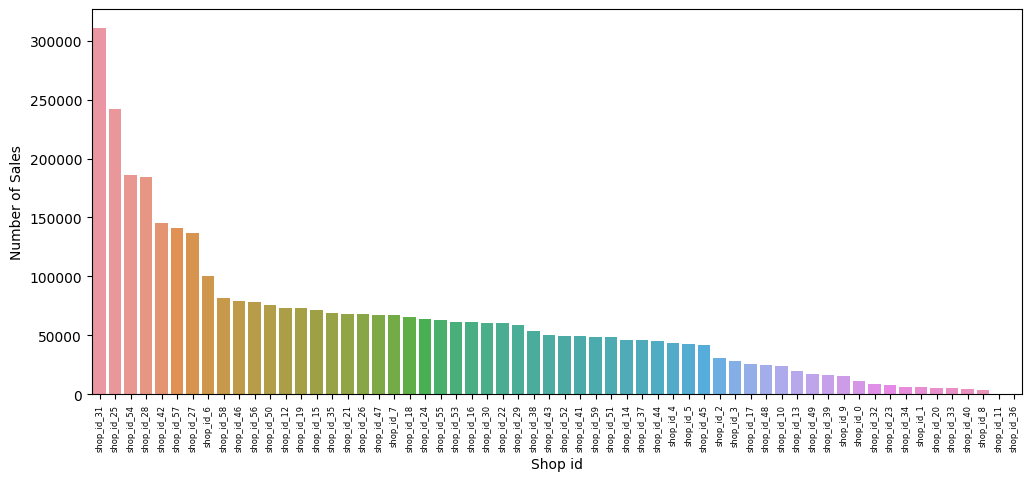

In [434]:
bar_plot_func(shops_sales, "Shop id", "Number of Sales")

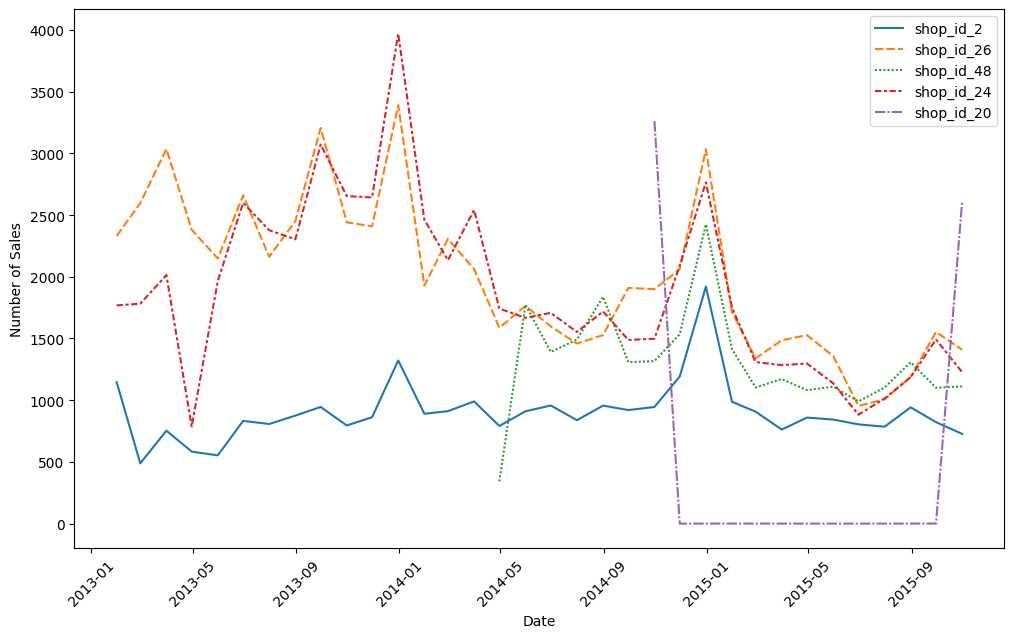

In [442]:
line_plot_func(shops_sales, number=5, ylabel="Number of Sales")

### Value of Sales (file name _shops\_values_)

In [395]:
shops_values = sort_sales(shops_local_df, "shop", "final_price")
shops_values.head()

shop_id_0  shop_id_1      shop_id_2  shop_id_3  shop_id_4  \
date                                                                    
2013-01-01        NaN        NaN   31886.000000        NaN        NaN   
2013-01-02        NaN        NaN   78307.007812    37305.0   122971.0   
2013-01-03   110588.0   108409.0  110521.000000    58891.0   102697.0   
2013-01-04   231122.0    45079.0   62854.000000    23231.0    88356.0   
2013-01-05   167500.0   103025.0   50181.000000    21771.0    52292.0   

            shop_id_5  shop_id_6  shop_id_7  shop_id_8  shop_id_9  ...  \
date                                                               ...   
2013-01-01        NaN        NaN    59993.0    44516.0        NaN  ...   
2013-01-02        NaN   147318.0   147332.0    97050.0        NaN  ...   
2013-01-03        NaN   133219.0   124552.0    73278.0        NaN  ...   
2013-01-04        NaN   123014.0    90173.0    80960.0        NaN  ...   
2013-01-05        NaN   107611.0   101877.0    61110.0        NaN  ...   

            shop_id_50  shop_id_51  shop_id_52  shop_id_53  shop_id_54  \
date                                                                     
2013-01-01         NaN     41411.0         NaN         NaN    319356.0   
2013-01-02    189892.0     56035.0     82783.0    105339.0    520884.0   
2013-01-03    169269.0     31080.0     76037.0     76952.5    377069.0   
2013-01-04    173310.0     37426.0     72385.0     98032.0    287218.0   
2013-01-05    143939.0     47338.0     28667.0     92861.0    401106.0   

            shop_id_55  shop_id_56  shop_id_57  shop_id_58  shop_id_59  
date                                                                    
2013-01-01         NaN         NaN         NaN         NaN         NaN  
2013-01-02         NaN    227756.0         NaN         NaN    146080.0  
2013-01-03         NaN    168691.0         NaN         NaN    156443.0  
2013-01-04         NaN    101474.0         NaN         NaN     84128.0  
2013-01-05         NaN     94114.0         NaN         NaN    103285.0  

[5 rows x 60 columns]

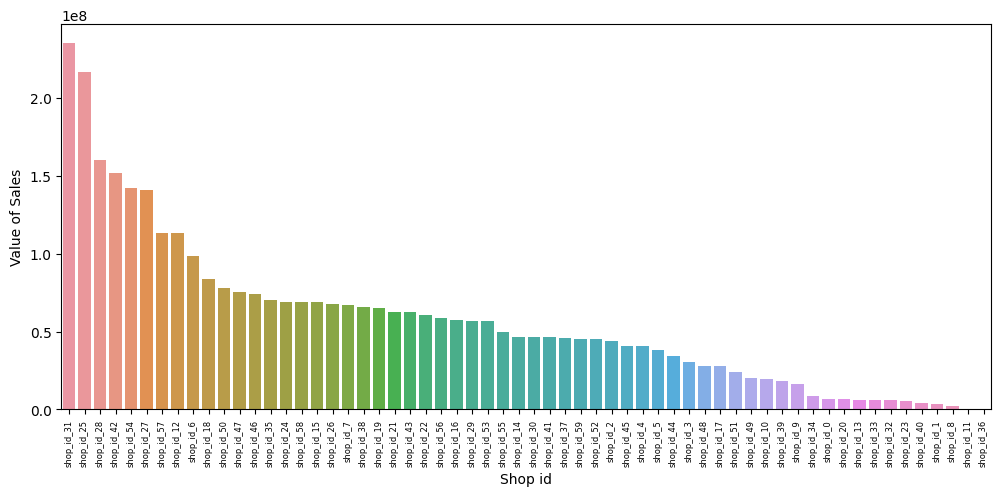

In [396]:
bar_plot_func(shops_values, "Shop id", "Value of Sales")

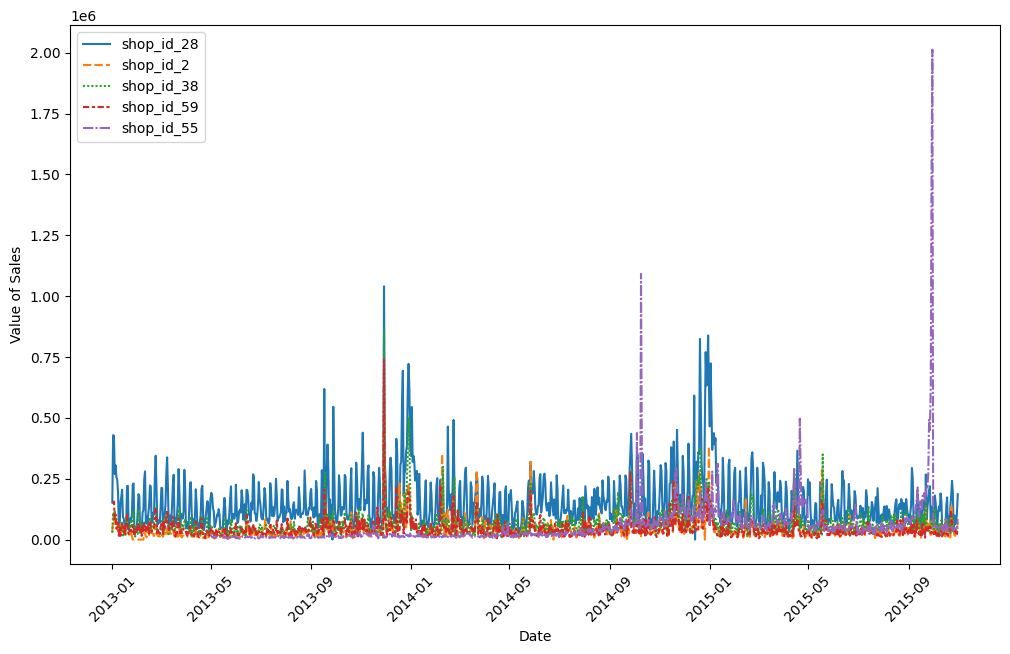

In [397]:
line_plot_func(shops_values, number=5, ylabel="Value of Sales")

## Group by Category

### Number of Sales  (file name _cats\_sales_)

In [398]:
cats_sales = sort_sales(categories_local_df, "cat", "item_cnt_day")
cats_sales.head()

cat_id_0  cat_id_1  cat_id_2  cat_id_3  cat_id_4  cat_id_5  \
date                                                                     
2013-01-01       NaN       NaN      30.0         7      10.0        12   
2013-01-02       NaN       NaN     116.0        41      18.0        58   
2013-01-03       NaN       NaN      84.0        32      17.0        56   
2013-01-04       NaN       NaN      77.0        24      19.0        33   
2013-01-05       NaN       NaN      79.0        25      15.0        46   

            cat_id_6  cat_id_7  cat_id_8  cat_id_9  ...  cat_id_74  cat_id_75  \
date                                                ...                         
2013-01-01        13       NaN       NaN       NaN  ...        NaN         17   
2013-01-02        64       NaN       NaN       NaN  ...        NaN         95   
2013-01-03        47       NaN       NaN       NaN  ...        NaN        126   
2013-01-04        43       NaN       NaN       NaN  ...        NaN        167   
2013-01-05        40       NaN       NaN       NaN  ...        NaN        110   

            cat_id_76  cat_id_77  cat_id_78  cat_id_79  cat_id_80  cat_id_81  \
date                                                                           
2013-01-01        NaN          4        NaN          1        NaN        1.0   
2013-01-02        NaN         31        NaN          7        NaN        9.0   
2013-01-03        NaN         30        NaN          1        NaN        7.0   
2013-01-04        NaN         16        NaN          7        NaN        8.0   
2013-01-05        NaN         18        NaN          7        NaN        7.0   

            cat_id_82  cat_id_83  
date                              
2013-01-01       16.0         35  
2013-01-02       71.0        113  
2013-01-03       41.0         64  
2013-01-04       62.0         32  
2013-01-05       57.0         38  

[5 rows x 84 columns]

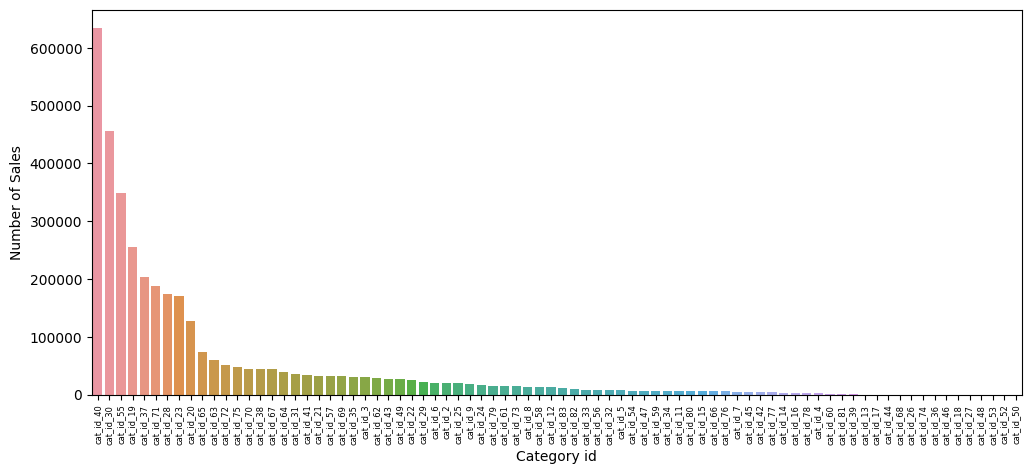

In [399]:
bar_plot_func(cats_sales, "Category id", "Number of Sales")

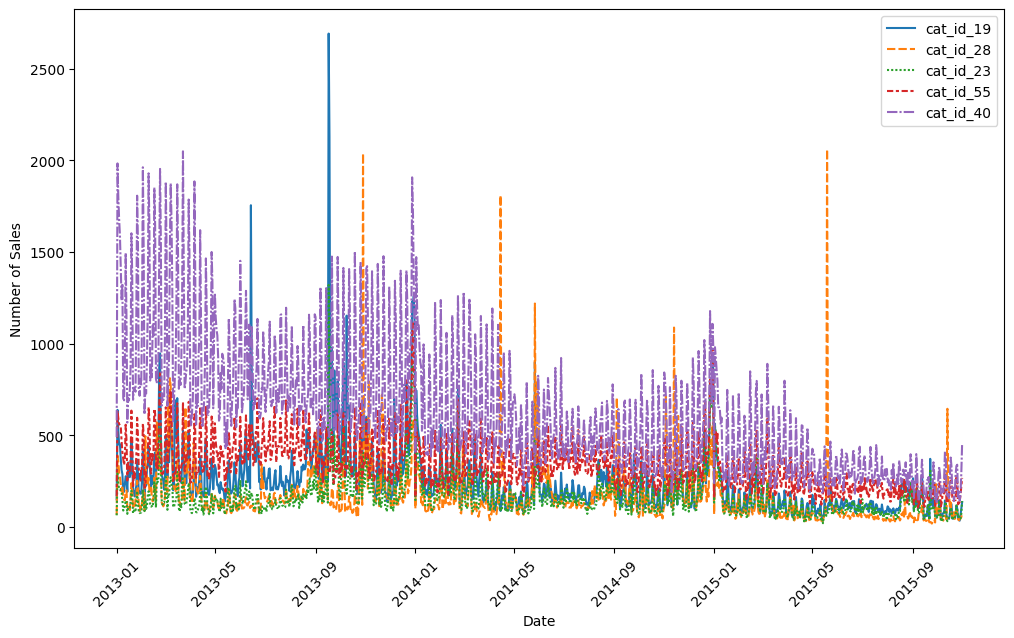

In [400]:
sample_id = ['cat_id_19', 'cat_id_28', 'cat_id_23', 'cat_id_55', 'cat_id_40']
line_plot_func(cats_sales, sample=sample_id, ylabel="Number of Sales")

### Value of Sales (file name _cats\_values_)

In [401]:
cats_values = sort_sales(categories_local_df, "cat", "final_price")
cats_values.head()

cat_id_0  cat_id_1       cat_id_2      cat_id_3  cat_id_4  \
date                                                                    
2013-01-01       NaN       NaN   59210.679688   3235.660156    5353.0   
2013-01-02       NaN       NaN  223635.234375  20455.240234   22371.0   
2013-01-03       NaN       NaN  166675.000000  15711.000000   20409.0   
2013-01-04       NaN       NaN  146496.515625  11205.000000   18681.5   
2013-01-05       NaN       NaN  142757.015625  11447.000000   14820.0   

                cat_id_5  cat_id_6  cat_id_7  cat_id_8  cat_id_9  ...  \
date                                                              ...   
2013-01-01   8647.299805   20769.0       NaN       NaN       NaN  ...   
2013-01-02  47024.078125  120656.5       NaN       NaN       NaN  ...   
2013-01-03  58698.320312   62046.5       NaN       NaN       NaN  ...   
2013-01-04  34044.699219   71060.0       NaN       NaN       NaN  ...   
2013-01-05  46100.101562   55896.0       NaN       NaN       NaN  ...   

            cat_id_74      cat_id_75  cat_id_76  cat_id_77  cat_id_78  \
date                                                                    
2013-01-01        NaN   32224.500000        NaN      696.0        NaN   
2013-01-02        NaN  188437.000000        NaN     5554.0        NaN   
2013-01-03        NaN  210710.796875        NaN     5693.0        NaN   
2013-01-04        NaN  262702.000000        NaN     2985.0        NaN   
2013-01-05        NaN  157989.703125        NaN     3792.0        NaN   

            cat_id_79  cat_id_80  cat_id_81  cat_id_82     cat_id_83  
date                                                                  
2013-01-01      499.0        NaN       79.0      447.0   2580.000000  
2013-01-02     3593.0        NaN     1871.0     2522.0  10122.870117  
2013-01-03      599.0        NaN      951.0     1023.0   5546.000000  
2013-01-04     3393.0        NaN     1568.0     1814.0   3013.000000  
2013-01-05     3623.0        NaN     1989.0     1662.0   3294.000000  

[5 rows x 84 columns]

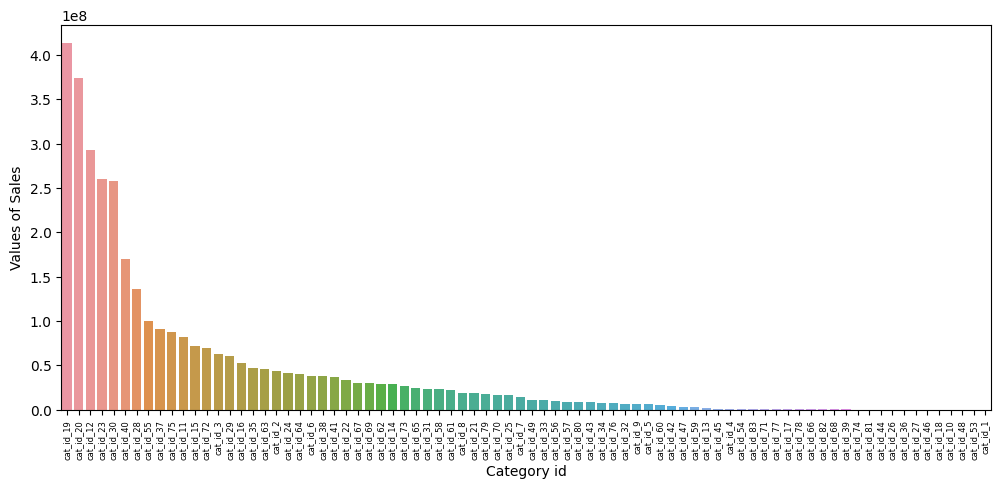

In [402]:
bar_plot_func(cats_values, "Category id", "Values of Sales")

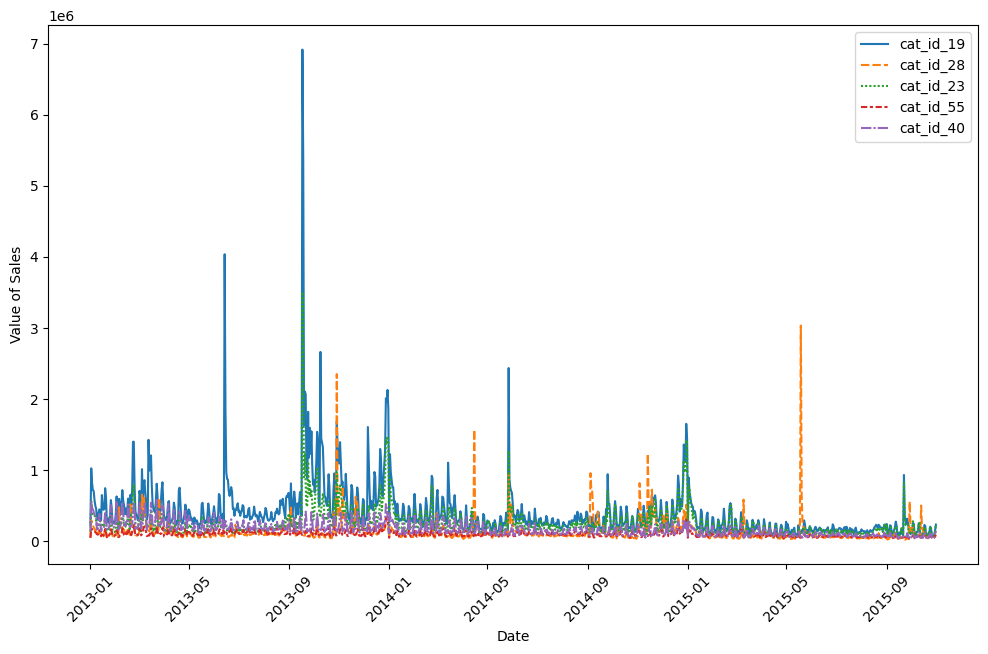

In [403]:
sample_id = ['cat_id_19', 'cat_id_28', 'cat_id_23', 'cat_id_55', 'cat_id_40']
line_plot_func(cats_values, sample=sample_id, ylabel="Value of Sales")

## Group by item

### Cleaning the data with the _test\_df_ Data Frame as base line

First we will remove the categories that don't show in the _test\_df_, to reduce the amount of data. The amount of data is to big, and will make analysis difficult. And those shops, categories and items have really small number on the sales.

In [404]:
unique_shops = np.sort(test_local_df['shop_id'].unique())
unique_shops, len(unique_shops)

(array([ 2,  3,  4,  5,  6,  7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 24, 25,
        26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47, 48, 49,
        50, 52, 53, 55, 56, 57, 58, 59]),
 42)

In [405]:
unique_cats = np.sort(test_local_df['cat_id'].unique())
unique_cats, len(unique_cats)

(array([ 0,  2,  3,  5,  6,  7,  9, 11, 12, 15, 16, 19, 20, 21, 22, 23, 24,
        25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43,
        44, 45, 47, 49, 54, 55, 56, 57, 58, 60, 61, 62, 63, 64, 65, 67, 69,
        70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 83]),
 62)

In [406]:
unique_item = np.sort(test_local_df['item_id'].unique())
unique_item, len(unique_item)

(array([   30,    31,    32, ..., 22164, 22166, 22167]), 5100)

In [407]:
sales_clean_df = sales_local_df[
    sales_local_df['shop_id'].isin(unique_shops)
    & sales_local_df['cat_id'].isin(unique_cats)
    & sales_local_df['item_id'].isin(unique_item)
]
sales_clean_df

date  date_block_num  shop_id  item_id  item_price  \
335923  2013-01-01               0       46     4885      1499.0   
802593  2013-01-01               0       28    16205       299.0   
804019  2013-01-01               0       38    15298      1259.0   
792445  2013-01-01               0       28    16180      1679.0   
350142  2013-01-01               0       42     5145       449.0   
...            ...             ...      ...      ...         ...   
2933651 2015-10-31              33       31     4054      2499.0   
2744319 2015-10-31              33       44     2430       499.0   
2743433 2015-10-31              33       38     2429      1199.0   
2933654 2015-10-31              33       25     4054      2499.0   
2934040 2015-10-31              33        5    17031       399.0   

         item_cnt_day  cat_id  final_price  
335923              1      23       1499.0  
802593              1      65        299.0  
804019              1      63       1259.0  
792445              1      64       1679.0  
350142              1      67        449.0  
...               ...     ...          ...  
2933651             2      19       4998.0  
2744319             1      20        499.0  
2743433             1      28       1199.0  
2933654             1      19       2499.0  
2934040             1      40        399.0  

[1224439 rows x 8 columns]

In [408]:
print(
    f"sales_local_df Rows: {sales_local_df.shape[0]}",
    f"sales_clean_df Reows: {sales_clean_df.shape[0]}",
    sep='\n'
)

sales_local_df Rows: 2935849
sales_clean_df Reows: 1224439


### Number of Sales (file name _items\_sales_)

In [409]:
items_sales = pd.pivot_table(
    sales_clean_df, values='item_cnt_day',
    index=['item_id'], columns=['date'],
    aggfunc=np.sum 
)
items_sales.fillna(0, inplace=True)
items_sales = items_sales.T

In [410]:
items_sales.head()

item_id     30     31     32     33     38     42     45     51     53     \
date                                                                        
2013-01-01    0.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0    0.0   12.0    3.0    0.0    0.0    1.0    0.0    1.0   
2013-01-03    0.0    0.0   15.0    1.0    0.0    0.0    1.0    2.0    1.0   
2013-01-04    0.0    0.0   11.0    2.0    0.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0    0.0   14.0    4.0    0.0    0.0    0.0    1.0    0.0   

item_id     57     ...  22111  22118  22139  22145  22154  22162  22163  \
date               ...                                                    
2013-01-01    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0  ...    0.0    0.0    1.0    0.0    3.0    0.0    0.0   
2013-01-03    0.0  ...    1.0    0.0    2.0    0.0    1.0    0.0    0.0   
2013-01-04    0.0  ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0  ...    0.0    0.0    1.0    0.0    1.0    0.0    0.0   

item_id     22164  22166  22167  
date                             
2013-01-01    0.0    0.0    0.0  
2013-01-02    0.0    0.0    0.0  
2013-01-03    0.0    0.0    0.0  
2013-01-04    0.0    0.0    0.0  
2013-01-05    0.0    0.0    0.0  

[5 rows x 4716 columns]

In [411]:
items_sales.sum().sort_values(ascending=False)

item_id
20949    154077.0
2808      13955.0
3732      13582.0
17717     13553.0
5822      12268.0
           ...   
12400         1.0
21001         1.0
21007         1.0
21010         1.0
5959          1.0
Length: 4716, dtype: float64

<AxesSubplot: ylabel='Percent'>

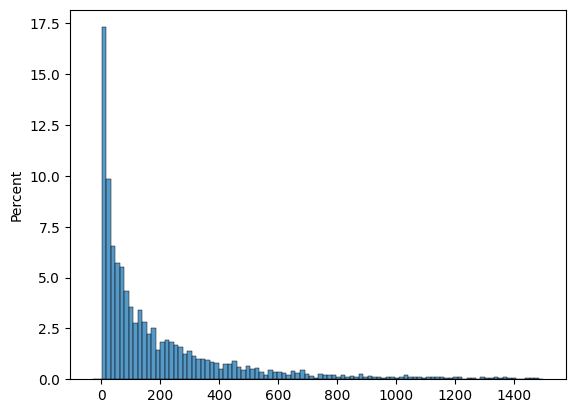

In [412]:
xxx = items_sales.sum().sort_values(ascending=False)
sns.histplot(xxx, stat='percent', bins=100, binrange=(-30, 1_500))
#plt.xlim(left=-100, right=1_500)
#plt.ylim(top=900)

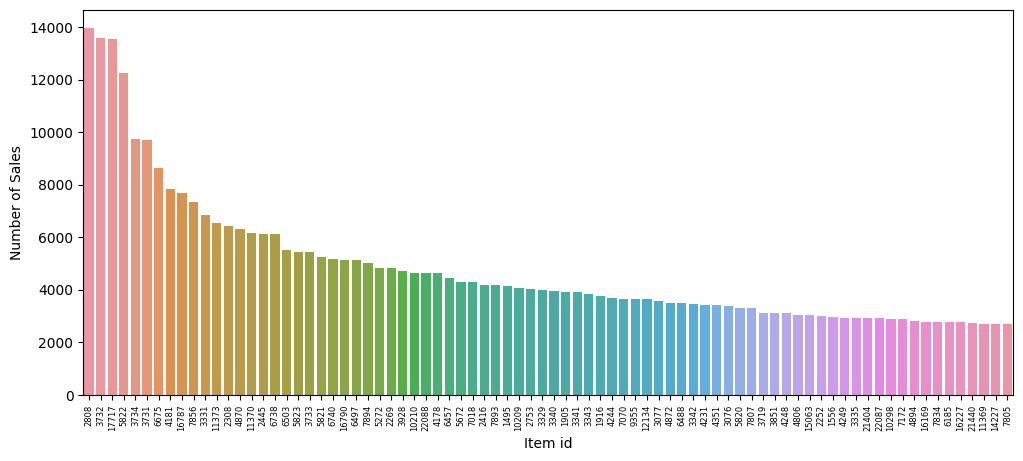

In [413]:
bar_plot_func(items_sales, "Item id", "Number of Sales", start=1)

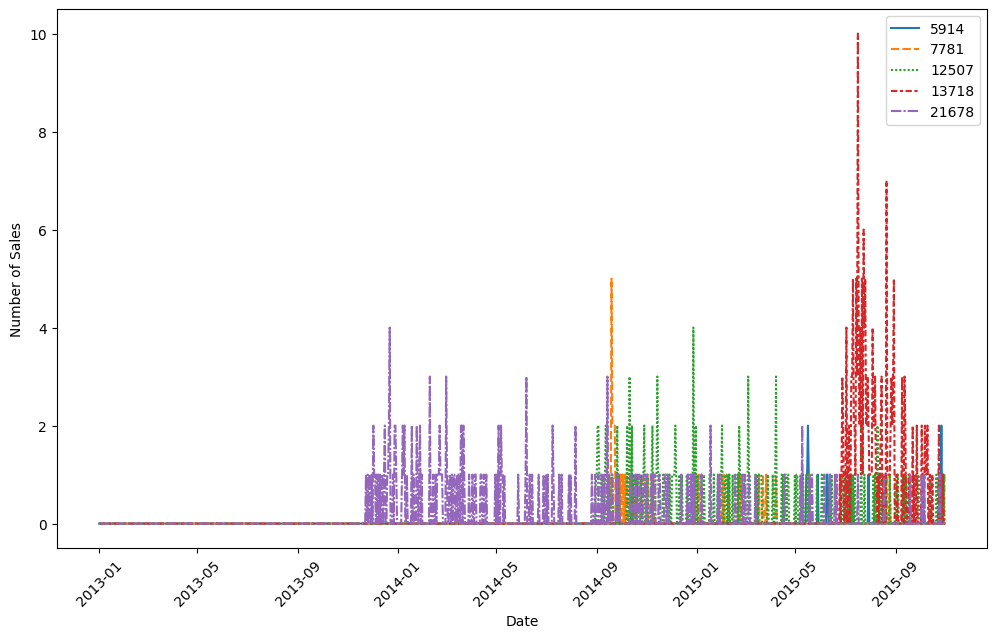

In [414]:
line_plot_func(items_sales, number=5, ylabel=f"Number of Sales")

### Values of Sales (file name _items\_values_)

In [415]:
items_values = pd.pivot_table(
    sales_clean_df, values='final_price',
    index=['item_id'], columns=['date'],
    aggfunc=np.sum 
)
items_values.fillna(0, inplace=True)
items_values = items_values.T

In [416]:
items_values.head()

item_id     30     31           32      33     38     42     45     51     \
date                                                                        
2013-01-01    0.0    0.0  1395.439941     0.0    0.0    0.0    0.0    0.0   
2013-01-02    0.0    0.0  4186.870117  1497.0    0.0    0.0  299.0    0.0   
2013-01-03    0.0    0.0  5217.549805   499.0    0.0    0.0  299.0  498.0   
2013-01-04    0.0    0.0  3839.000000   998.0    0.0    0.0    0.0    0.0   
2013-01-05    0.0    0.0  4886.000000  1996.0    0.0    0.0    0.0  249.0   

item_id     53     57     ...  22111  22118        22139  22145   22154  \
date                      ...                                             
2013-01-01    0.0    0.0  ...    0.0    0.0     0.000000    0.0     0.0   
2013-01-02  299.0    0.0  ...    0.0    0.0   791.119995    0.0  2997.0   
2013-01-03  299.0    0.0  ...  349.0    0.0  1998.000000    0.0   999.0   
2013-01-04    0.0    0.0  ...    0.0    0.0     0.000000    0.0     0.0   
2013-01-05    0.0    0.0  ...    0.0    0.0   899.369995    0.0   999.0   

item_id     22162  22163  22164  22166  22167  
date                                           
2013-01-01    0.0    0.0    0.0    0.0    0.0  
2013-01-02    0.0    0.0    0.0    0.0    0.0  
2013-01-03    0.0    0.0    0.0    0.0    0.0  
2013-01-04    0.0    0.0    0.0    0.0    0.0  
2013-01-05    0.0    0.0    0.0    0.0    0.0  

[5 rows x 4716 columns]

In [417]:
items_values.sum().sort_values(ascending=False)

item_id
6675     185097376.0
3732      35825964.0
3734      26103438.0
3731      19258302.0
3733      18826444.0
            ...     
18707          149.0
8247           149.0
342            144.0
4491            99.0
180             80.0
Length: 4716, dtype: float32

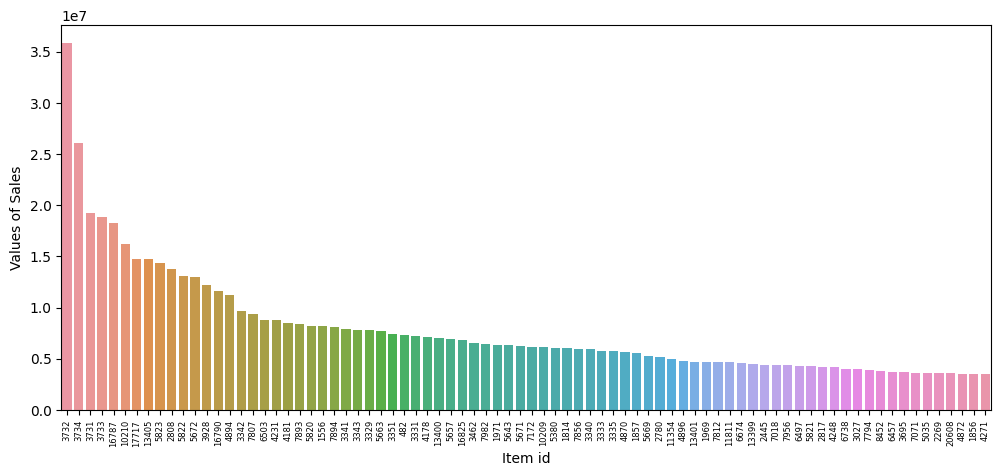

In [418]:
bar_plot_func(items_values, "Item id", "Values of Sales", start=1)

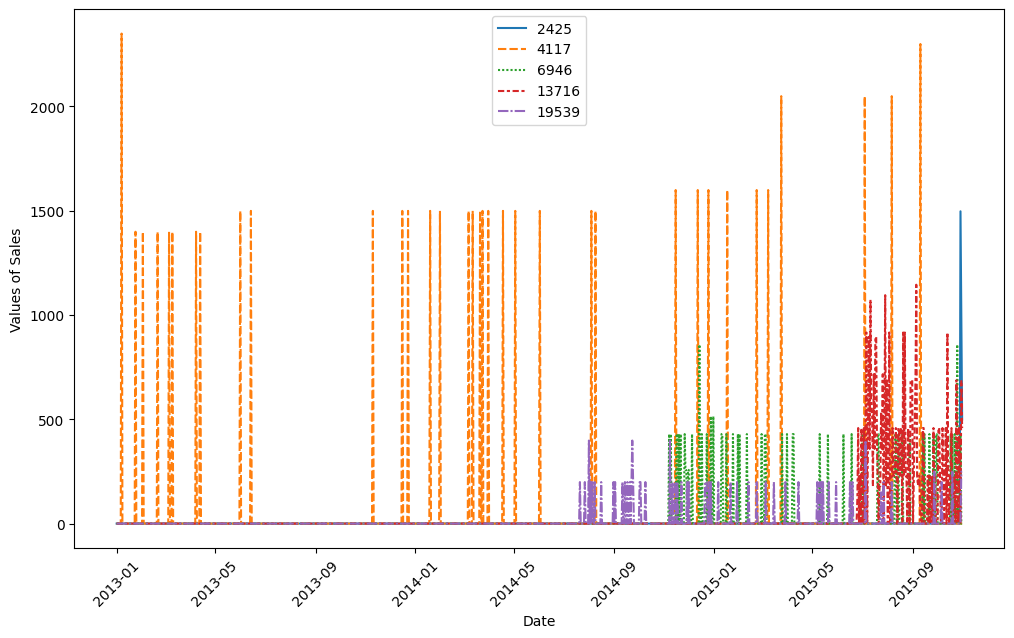

In [419]:
line_plot_func(items_values, number=5, ylabel=f"Values of Sales")

## Group  Categories by Shop

### Number of Sales (file name _cats_shops_sales_)

In [420]:
cats_shops_sales = pd.pivot_table(
    sales_clean_df, values='item_cnt_day',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
cats_shops_sales.fillna(0, inplace=True)
cats_shops_sales = cats_shops_sales.T

In [421]:
cats_shops_sales.head()

shop_id      2                                                ...   59       \
cat_id       2    3    5    6    7    11   12   15   16   19  ...   67   69   
date                                                          ...             
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2013-01-02  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  2.0  0.0   
2013-01-03  2.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0 -2.0   
2013-01-04  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  3.0  0.0   
2013-01-05  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.0  ...  1.0  0.0   

shop_id                                             
cat_id       70   71   72   73   75   77   79   83  
date                                                
2013-01-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-02  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2013-01-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
2013-01-04  0.0  0.0  0.0  0.0  3.0  0.0  0.0  0.0  
2013-01-05  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  

[5 rows x 2008 columns]

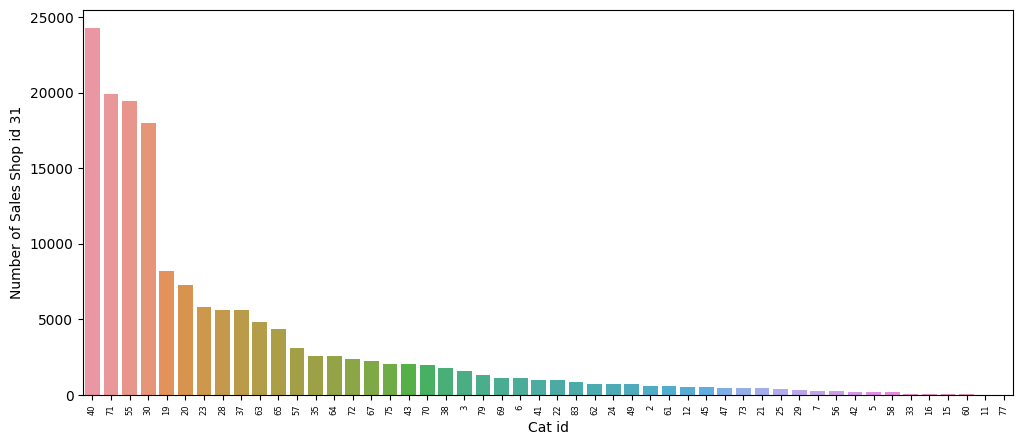

In [422]:
shop_id = 31
bar_plot_func(cats_shops_sales[shop_id], "Cat id", f"Number of Sales Shop id {shop_id}")

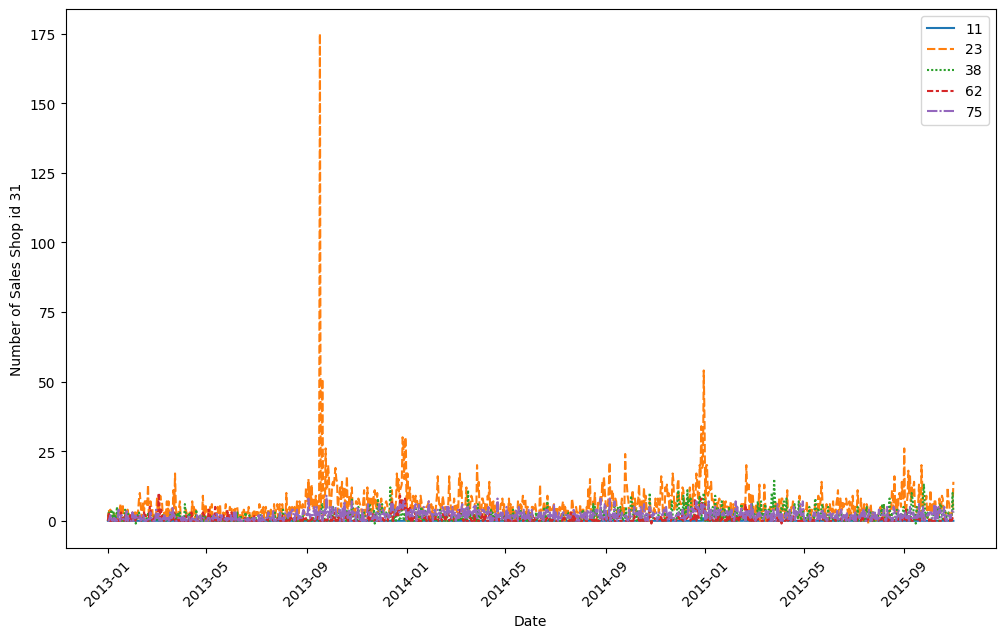

In [423]:
line_plot_func(cats_shops_sales[shop_id], number=5, ylabel=f"Number of Sales Shop id {shop_id}")

### Value of Sales (file name cats_shops_values)

In [424]:
cats_shops_values = pd.pivot_table(
    sales_clean_df, values='final_price',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
cats_shops_values.fillna(0, inplace=True)
cats_shops_values = cats_shops_values.T

In [425]:
cats_shops_values.head()

shop_id         2                                                             \
cat_id          2    3           5       6    7    11   12   15   16      19   
date                                                                           
2013-01-01     0.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2013-01-02  3180.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0  1199.0   
2013-01-03  3180.0  0.0  489.299988  1990.0  0.0  0.0  0.0  0.0  0.0  1798.0   
2013-01-04     0.0  0.0  699.000000     0.0  0.0  0.0  0.0  0.0  0.0     0.0   
2013-01-05  1590.0  0.0    0.000000     0.0  0.0  0.0  0.0  0.0  0.0  2698.0   

shop_id     ...      59                                                   
cat_id      ...      67   69   70   71   72   73      75   77   79    83  
date        ...                                                           
2013-01-01  ...     0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  
2013-01-02  ...  1298.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  
2013-01-03  ...   299.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  79.0  
2013-01-04  ...  1670.0  0.0  0.0  0.0  0.0  0.0  3450.0  0.0  0.0   0.0  
2013-01-05  ...   949.0  0.0  0.0  0.0  0.0  0.0  3500.0  0.0  0.0   0.0  

[5 rows x 2008 columns]

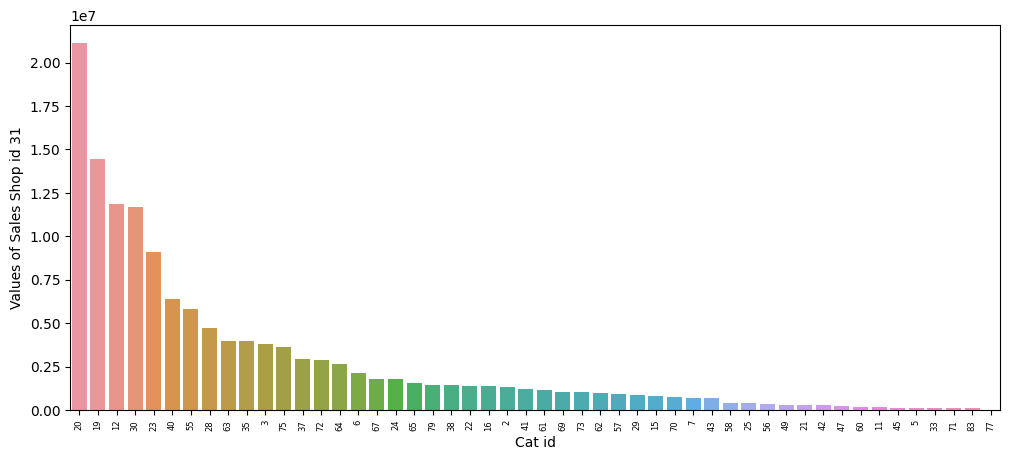

In [426]:
shop_id = 31
bar_plot_func(cats_shops_values[shop_id], "Cat id", f"Values of Sales Shop id {shop_id}")

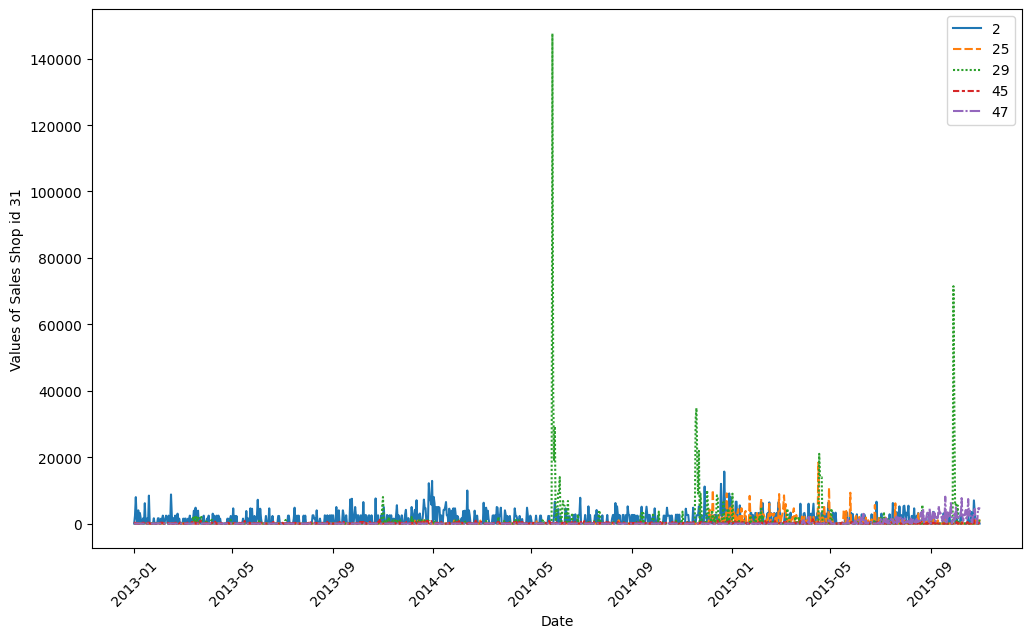

In [427]:
line_plot_func(cats_shops_values[shop_id], number=5, ylabel=f"Values of Sales Shop id {shop_id}")

## Total

### Files names: _total\_sales_ and _total\_values_

In [428]:
total_sales = sales_local_df.resample(freq_analysis, on="date").sum()[['item_cnt_day']]
total_values = sales_local_df.resample(freq_analysis, on="date").sum()[['final_price']]

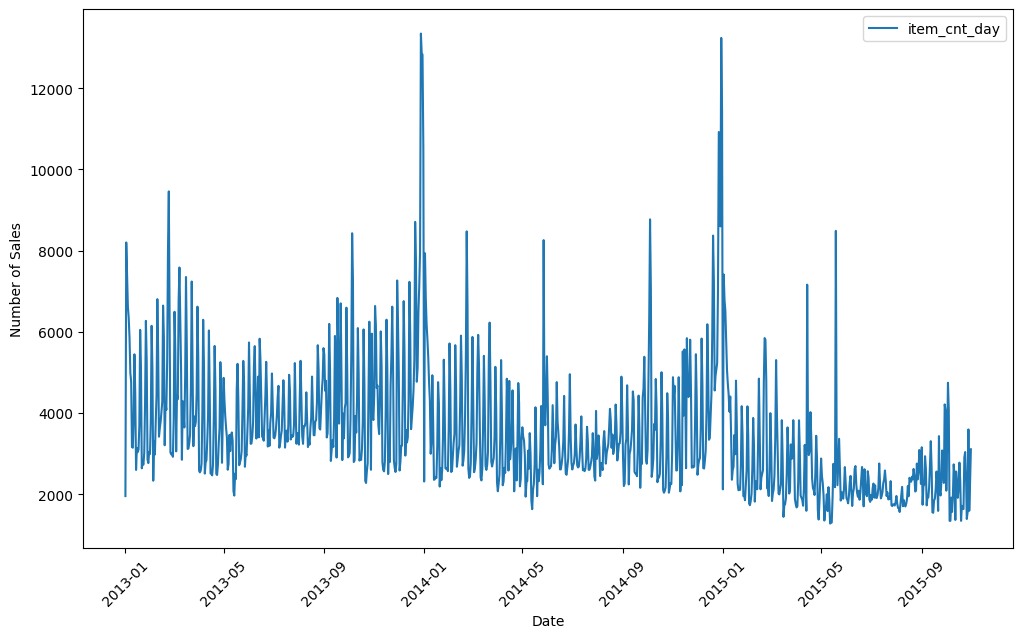

In [429]:
line_plot_func(total_sales, 1, ylabel="Number of Sales")

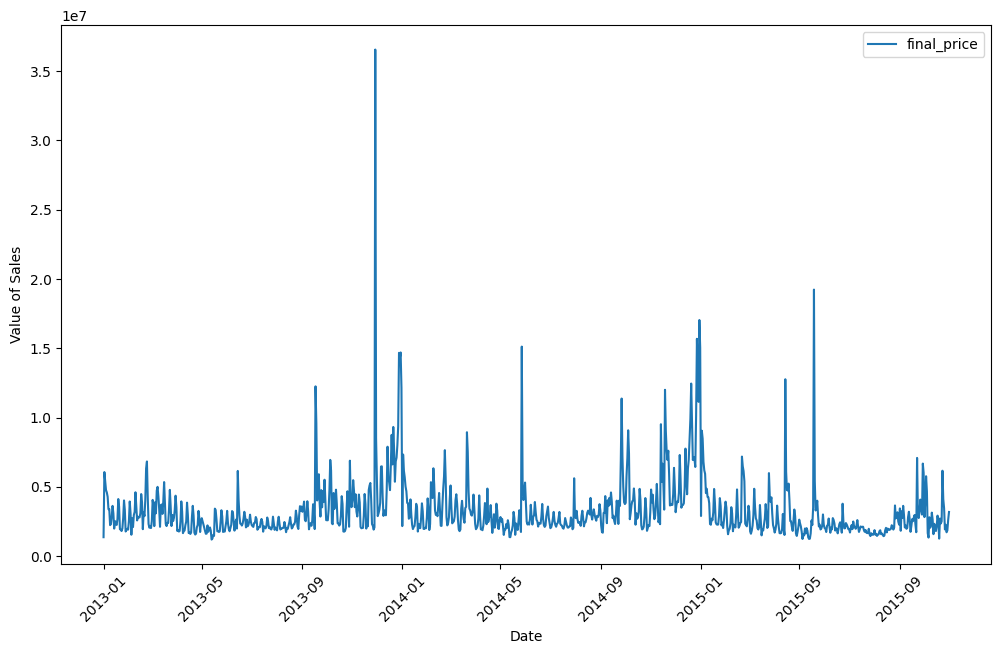

In [430]:
line_plot_func(total_values, 1, ylabel="Value of Sales")

# Model Prophet
___

## Model Functions

In [56]:
# plot graph with train test and predict
def plot_forecast(prophet_dict: dict, test=True, pred=True, lower=False, upper=False, left=None, right=None) -> None:
    """
    Plot the train, test and forecast data.
    prophet_dict: prophet_model dictionary
    test, pred, lower, upper: turn on and off the plots.
    left, right: sets the x-axis limits, in date format.
    """
    plt.figure(figsize=(15, 8))
    
    # plots
    plt.plot(prophet_dict['train']['ds'], prophet_dict['train']['y'], label="Train")
    if test:
        plt.plot(prophet_dict['test']['ds'], prophet_dict['test']['y'], label="Test")
    if pred:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat'],
            label="Pred")
    if lower:
        plt.plot(
            prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
            prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_lower'],
            label="Lower")
    if upper:
        plt.plot(prophet_dict['forecast'][-prophet_dict['horizon']:]['ds'],
                 prophet_dict['forecast'][-prophet_dict['horizon']:]['yhat_upper'],
                 label="Upper")
    
    # x and y axis limits
    if left is not None:
        left = dt.datetime.strptime(left, '%Y-%m').date()
    if right is not None:
        right = dt.datetime.strptime(right, '%Y-%m').date()
    plt.xlim(left=left, right=right)    
    
    plt.legend(loc="best")
    plt.show()

In [57]:
# function to split the data between train and test
def set_train_data(df, split, frequency):
    """
    Split the Data Frame between train and test, if there is no need for test use split=1.
    df: Data Frame
    split: size (%) of the train data
    frequency: month, week, day
    """
    
    # Rename Columns to Prophet format
    df = df.reset_index()
    df.columns = ['ds', 'y']
    
    # Set size train and test df
    shape = df.shape[0]
    train_size = int(shape * split)
    train = df.iloc[:train_size]
    test = df.iloc[train_size:]
    
    # Set the horizin to predict
    horizon_dict = {'m': 2, 'w': 8, 'd':62} # two month, four weeks, 62 days
    horizon = (horizon_dict[frequency]) + (shape - train_size)
    return train, test, horizon

In [99]:
# fit the Prophet model
def prophet_model(df, split=0.9, seas_scale=10, inter_w=0.80, freq='d') -> dict:
    """
    Fit the whole model with FB Prophet.
    ------------------------------------
    data: the data to be used.
    split: Split between train and test, if there is no need for test use split=1.
    (seas_scale) seasonality_prior_scale:
        Larger values allow the model to fit larger seasonal fluctuations,
        smaller values dampen the seasonality.
    (inter_w) interval_width:
        Float, width of the uncertainty intervals provided for the forecast.
        Uses the MAP estimate of the extrapolated generative model.
    freq: Used to create the frequency (day, week, month), of train, test, forecast and horizon
    """
    # Split the data
    train_df, test_local_df, horizon = set_train_data(df, split, freq)
    
    # Prophet model fit
    model = prophet_fit(train_df, seas_scale, inter_w)
    
    # future prediction
    forecast = future_preds(model, horizon, freq)
    
    # dict with model, split data and forecast
    prophet_dict = {'model':model,
        'forecast':forecast,
        'train':train_df,
        'test':test_local_df,
        'horizon':horizon
    }
    
    return prophet_dict

In [59]:
# Prophet model
def prophet_fit(train_df, seas_scale, inter_w):
    model = Prophet(
        seasonality_mode='multiplicative', # or 'additive'
        seasonality_prior_scale=seas_scale, # default 10, smaller values dampen the seasonality
        interval_width=inter_w, # deaful 0.8, if mcmc < 0 will be integrated over all model parameters
        growth='linear', # is the default
        #yearly_seasonality=False, # default 'auto'
        #weekly_seasonality=True, # default 'auto'
        #daily_seasonality=False, # default 'auto'
        mcmc_samples=0, # default 0, if greater than 0, will do full Bayesian inference
    )
    return model.fit(train_df)    

In [60]:
# make future predictions
def future_preds(model, horizon, freq):
    """
    Return the forecast for a given model, frequency and horizon
    """
    future = model.make_future_dataframe(periods=horizon, freq=freq, )
    forecast = model.predict(future)
    # forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
    return forecast    

In [209]:
def get_forecast_data(prophet_dict: dict):
    """
    Input is the dict return of the prophet_model function.
    Get the forecast for the predictions, by days (61), weeks (4) or month (2).
    """
    row_start = prophet_dict['train'].shape[0] + prophet_dict['test'].shape[0] + 1
    df = prophet_dict['forecast'][row_start:][['ds', 'yhat']]
    
    day_pred = df[['ds']].join(df['yhat'].round(2))
    week_pred = day_pred.resample('w', on='ds').mean().round(2).head(8)
    month_pred = day_pred.resample('m', on='ds').mean().round(2).head(2)
    
    forecast = {
        'day': day_pred,
        'week': week_pred,
        'month': month_pred
    }
    
    return forecast

In [127]:
def get_forecast_data(prophet_dict: dict):
    """
    Input is the dict return of the prophet_model function.
    Get the forecast for the predictions, by days (61), weeks (4) or month (2).
    """
    row_start = prophet_dict['train'].shape[0]+1
    df = prophet_dict['forecast'][row_start:][['ds', 'yhat']]
    
    day_pred = df[['ds']].join(df['yhat'].round(2))
    week_pred = day_pred.resample('w', on='ds').mean().round(2).head(8)
    month_pred = day_pred.resample('m', on='ds').mean().round(2).head(2)
    
    forecast = {
        'day': day_pred,
        'week': week_pred,
        'month': month_pred
    }
    
    return forecast

## Evaluate Model for Total Data, _sales_ and _values_

### Fitting the Data and Making Future Predictions

In [62]:
# total_Shops_Number_sales
prophet_total_shops_sales = prophet_model(
    total_sales,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

# total_Shops_Values
prophet_total_shops_values = prophet_model(
    total_values,
    split=0.90,
    seas_scale=10,
    inter_w=0.80,
    freq=freq_analysis
)

09:11:10 - cmdstanpy - INFO - Chain [1] start processing
09:11:10 - cmdstanpy - INFO - Chain [1] done processing
09:11:11 - cmdstanpy - INFO - Chain [1] start processing
09:11:11 - cmdstanpy - INFO - Chain [1] done processing


### Plotting the forecast test

#### Total Number of Sales

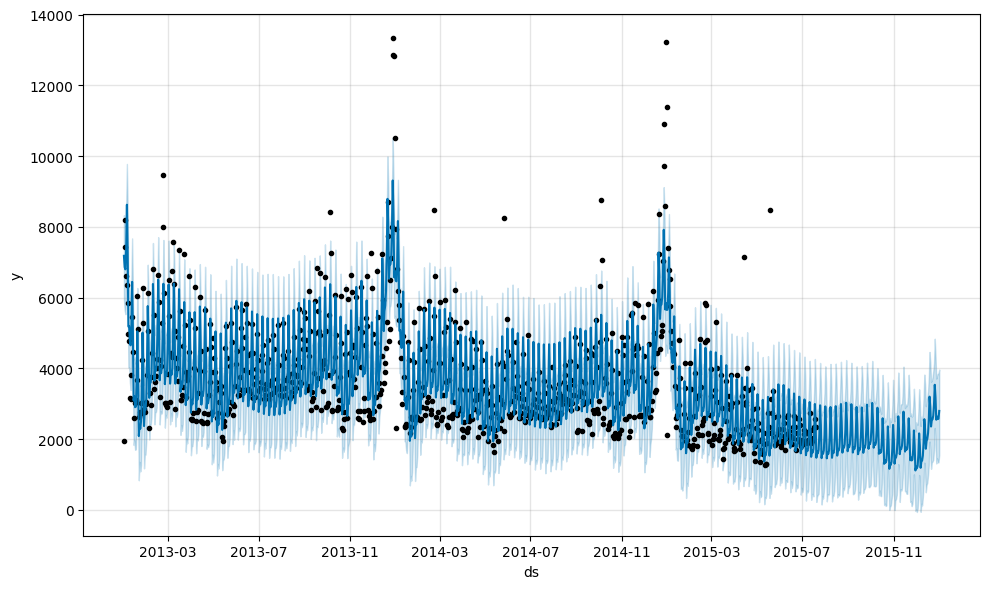

In [63]:
prophet_total_shops_sales['model'].plot(prophet_total_shops_sales['forecast']);

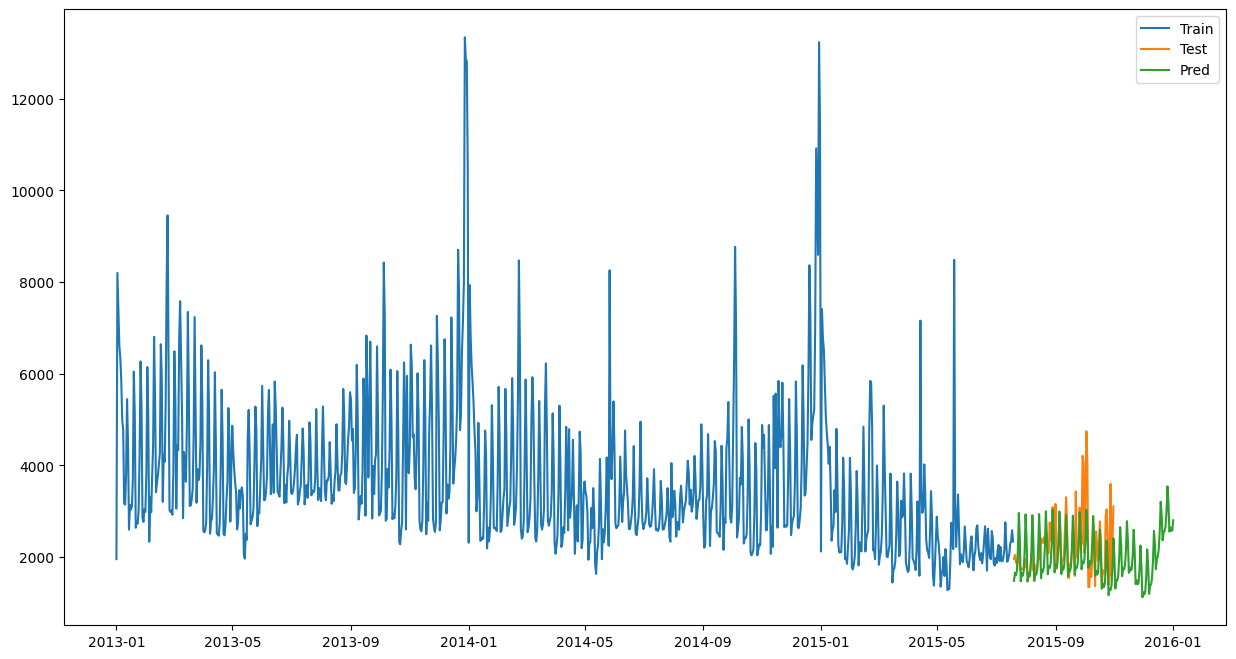

In [64]:
plot_forecast(prophet_total_shops_sales)

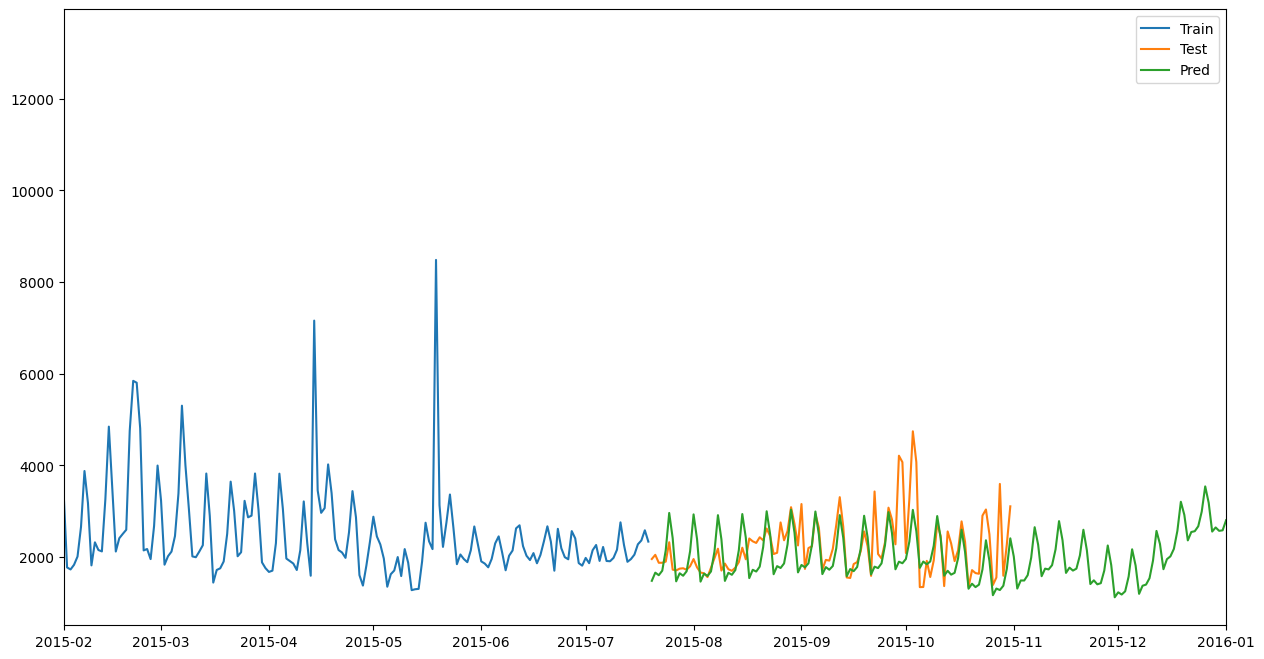

In [65]:
plot_forecast(prophet_total_shops_sales, left='2015-02', right='2016-01')

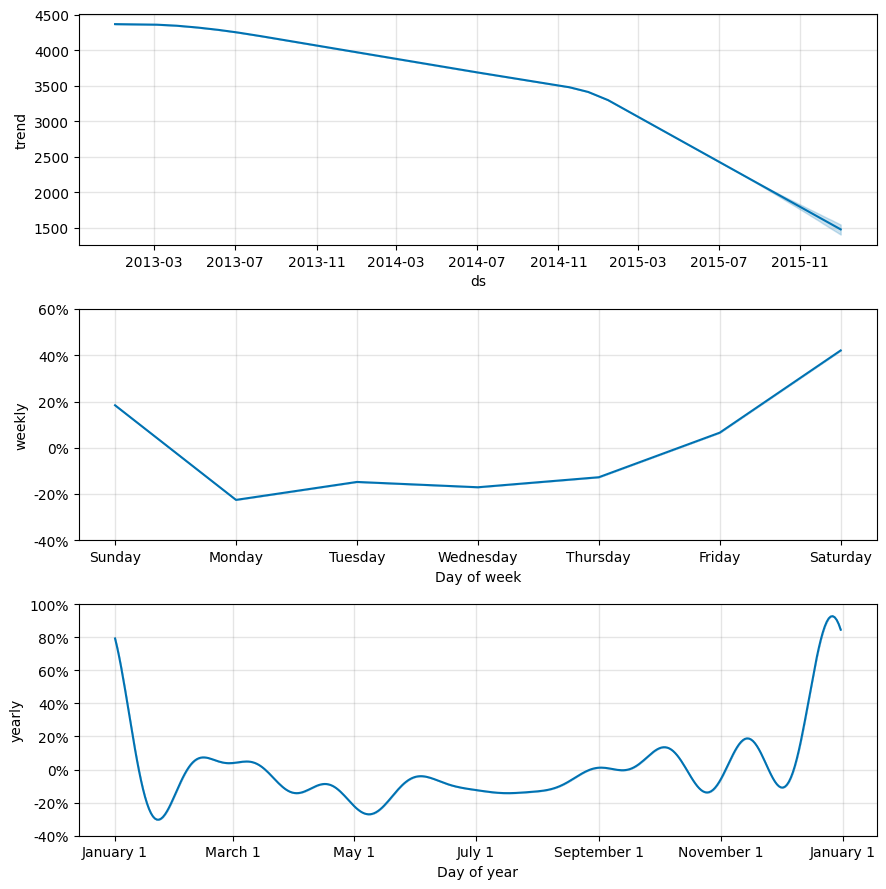

In [66]:
prophet_total_shops_sales['model'].plot_components(prophet_total_shops_sales['forecast']);

#### Total Value of Sales

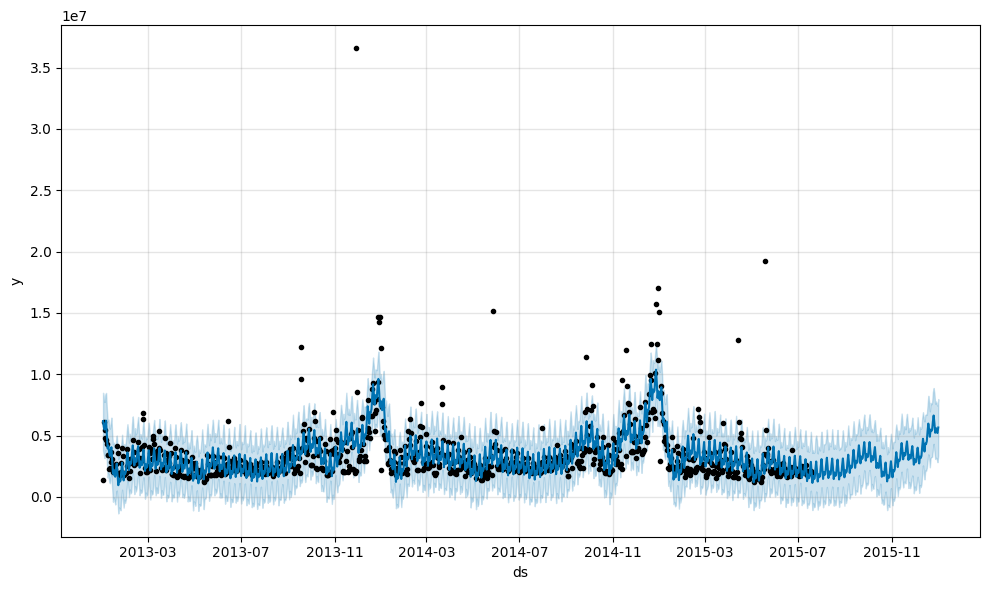

In [67]:
prophet_total_shops_values['model'].plot(prophet_total_shops_values['forecast']);

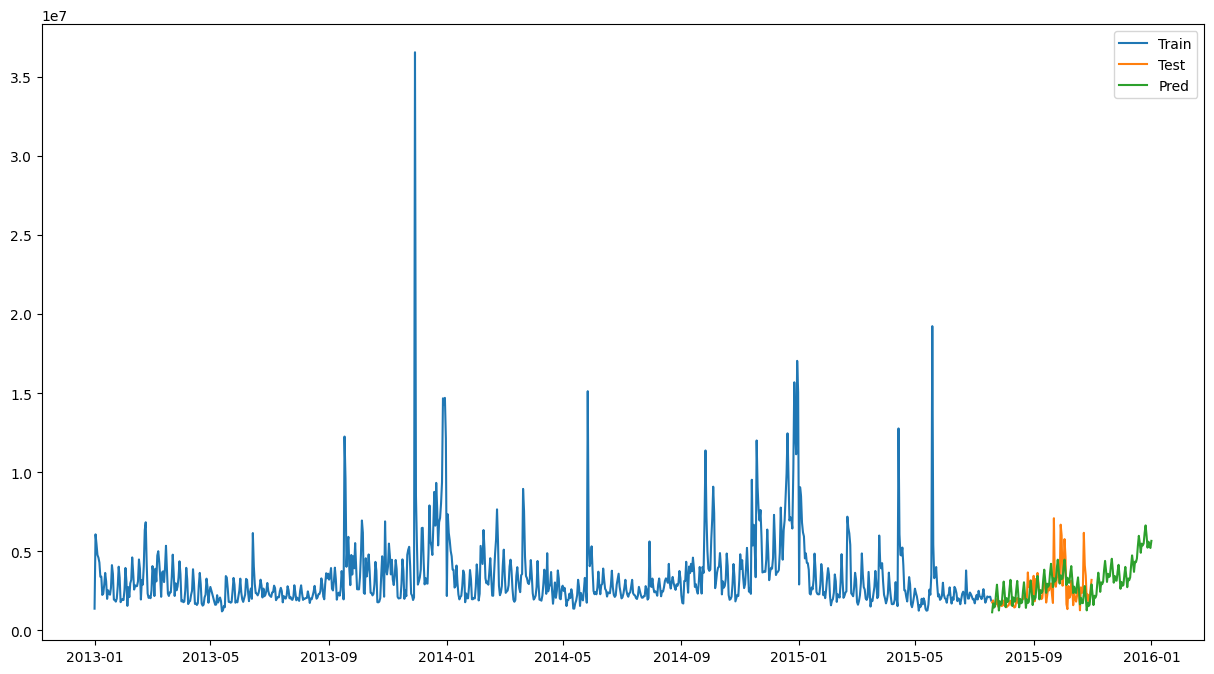

In [68]:
plot_forecast(prophet_total_shops_values)

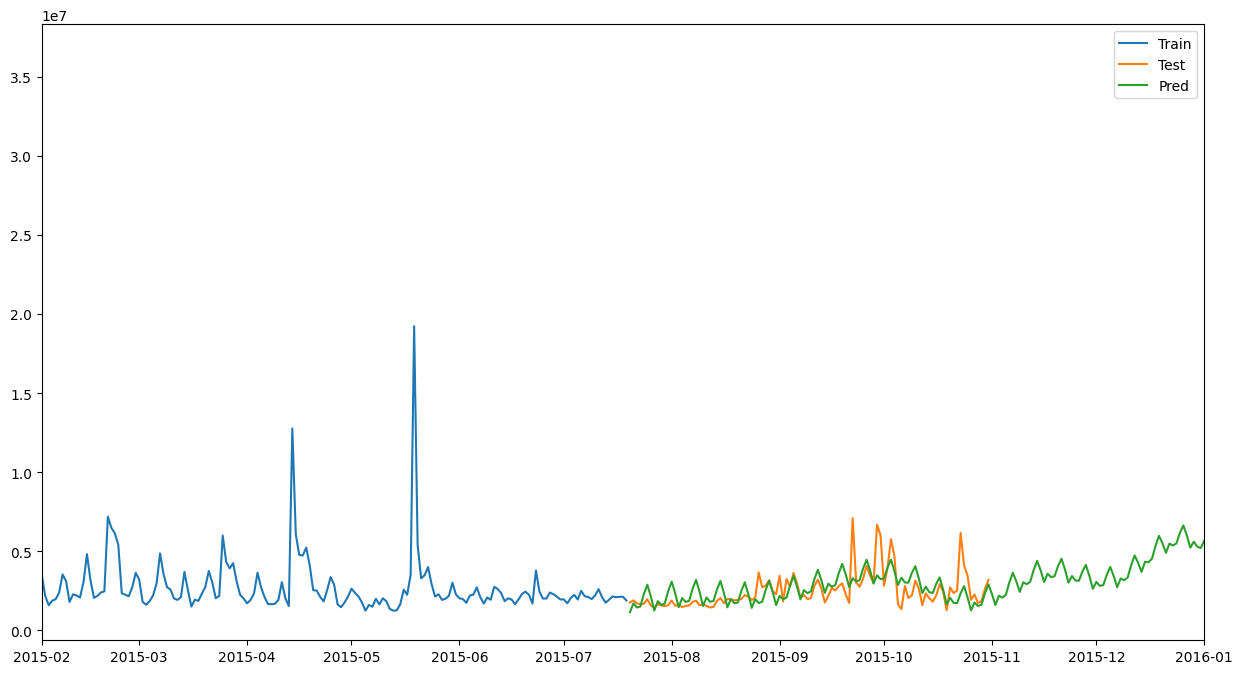

In [69]:
plot_forecast(prophet_total_shops_values, left='2015-02', right='2016-01')

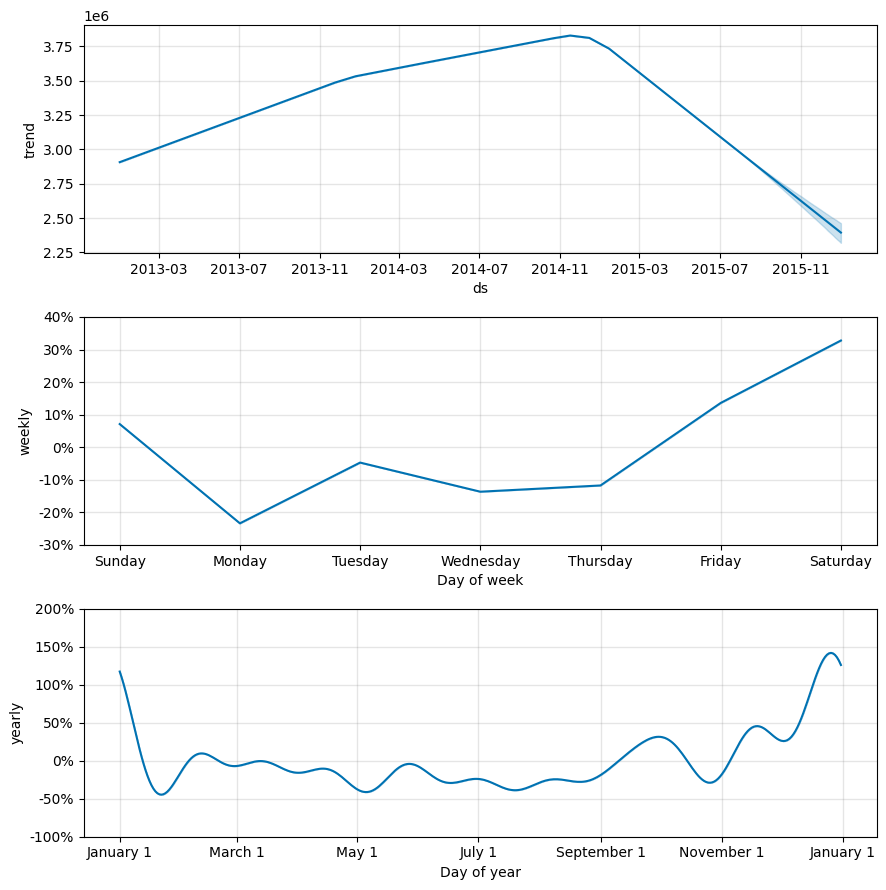

In [70]:
prophet_total_shops_values['model'].plot_components(prophet_total_shops_values['forecast']);

### Cross-Validation

In [71]:
# cross-validation for frequency daily
cv_results = cross_validation(
    model=prophet_total_shops_values['model'],
    initial='365.25 days', # one year
    horizon='31 days', # one month
    period='7 days'
)

  0%|          | 0/77 [00:00<?, ?it/s]

09:12:37 - cmdstanpy - INFO - Chain [1] start processing
09:12:37 - cmdstanpy - INFO - Chain [1] done processing
09:12:38 - cmdstanpy - INFO - Chain [1] start processing
09:12:38 - cmdstanpy - INFO - Chain [1] done processing
09:12:38 - cmdstanpy - INFO - Chain [1] start processing
09:12:38 - cmdstanpy - INFO - Chain [1] done processing
09:12:38 - cmdstanpy - INFO - Chain [1] start processing
09:12:38 - cmdstanpy - INFO - Chain [1] done processing
09:12:38 - cmdstanpy - INFO - Chain [1] start processing
09:12:38 - cmdstanpy - INFO - Chain [1] done processing
09:12:39 - cmdstanpy - INFO - Chain [1] start processing
09:12:39 - cmdstanpy - INFO - Chain [1] done processing
09:12:39 - cmdstanpy - INFO - Chain [1] start processing
09:12:39 - cmdstanpy - INFO - Chain [1] done processing
09:12:39 - cmdstanpy - INFO - Chain [1] start processing
09:12:39 - cmdstanpy - INFO - Chain [1] done processing
09:12:39 - cmdstanpy - INFO - Chain [1] start processing
09:12:40 - cmdstanpy - INFO - Chain [1]

09:12:57 - cmdstanpy - INFO - Chain [1] done processing
09:12:58 - cmdstanpy - INFO - Chain [1] start processing
09:12:58 - cmdstanpy - INFO - Chain [1] done processing
09:12:58 - cmdstanpy - INFO - Chain [1] start processing
09:12:58 - cmdstanpy - INFO - Chain [1] done processing
09:12:58 - cmdstanpy - INFO - Chain [1] start processing
09:12:58 - cmdstanpy - INFO - Chain [1] done processing
09:12:59 - cmdstanpy - INFO - Chain [1] start processing
09:12:59 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
cv_results

ds          yhat    yhat_lower    yhat_upper           y  \
0    2014-01-03  1.342015e+07  1.109056e+07  1.590276e+07  6157385.00   
1    2014-01-04  1.372014e+07  1.137025e+07  1.606428e+07  5692653.00   
2    2014-01-05  1.200881e+07  9.498904e+06  1.437913e+07  5023962.00   
3    2014-01-06  9.763866e+06  7.311702e+06  1.220028e+07  4686706.00   
4    2014-01-07  1.050393e+07  7.936998e+06  1.302303e+07  3847043.00   
...         ...           ...           ...           ...         ...   
2382 2015-07-15  1.581451e+06 -7.846598e+05  3.997828e+06  2143850.50   
2383 2015-07-16  1.618025e+06 -5.835866e+05  3.974375e+06  2098436.75   
2384 2015-07-17  2.404855e+06 -6.164424e+04  4.486484e+06  2120300.25   
2385 2015-07-18  2.997321e+06  5.869491e+05  5.337027e+06  2127450.00   
2386 2015-07-19  2.163416e+06 -1.910241e+05  4.434860e+06  1884871.50   

         cutoff  
0    2014-01-02  
1    2014-01-02  
2    2014-01-02  
3    2014-01-02  
4    2014-01-02  
...         ...  
2382 2015-06-18  
2383 2015-06-18  
2384 2015-06-18  
2385 2015-06-18  
2386 2015-06-18  

[2387 rows x 6 columns]

In [73]:
df_p = performance_metrics(cv_results)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0   4 days  2.005671e+12  1.416217e+06  9.547763e+05  0.268727  0.213400   
1   5 days  4.621689e+12  2.149811e+06  1.125786e+06  0.321750  0.246580   
2   6 days  5.008448e+12  2.237956e+06  1.198436e+06  0.358960  0.273054   
3   7 days  5.450523e+12  2.334635e+06  1.289077e+06  0.381271  0.293774   
4   8 days  3.533105e+12  1.879656e+06  1.228370e+06  0.383346  0.283996   
5   9 days  3.393559e+12  1.842162e+06  1.244552e+06  0.360049  0.266363   
6  10 days  3.173764e+12  1.781506e+06  1.191037e+06  0.329655  0.224198   
7  11 days  2.382294e+12  1.543468e+06  1.023985e+06  0.304783  0.205246   
8  12 days  4.902762e+12  2.214218e+06  1.167169e+06  0.355770  0.228508   
9  13 days  5.177450e+12  2.275401e+06  1.212554e+06  0.384889  0.274844   
10 14 days  5.437201e+12  2.331781e+06  1.270869e+06  0.392368  0.262090   
11 15 days  3.255611e+12  1.804331e+06  1.197508e+06  0.381536  0.276424   
12 16 days  2.974495e+12  1.724672e+06  1.213999e+06  0.356216  0.263664   
13 17 days  2.701893e+12  1.643744e+06  1.169449e+06  0.325975  0.248494   
14 18 days  2.028320e+12  1.424191e+06  1.006560e+06  0.303325  0.219082   
15 19 days  4.602970e+12  2.145453e+06  1.150203e+06  0.347776  0.235390   
16 20 days  4.968225e+12  2.228952e+06  1.201721e+06  0.377909  0.287074   
17 21 days  5.251552e+12  2.291627e+06  1.266227e+06  0.386581  0.278841   
18 22 days  3.056443e+12  1.748269e+06  1.186531e+06  0.378209  0.269745   
19 23 days  2.731470e+12  1.652716e+06  1.192547e+06  0.352033  0.256068   
20 24 days  2.485760e+12  1.576629e+06  1.148988e+06  0.323202  0.241930   
21 25 days  1.887867e+12  1.373997e+06  9.957435e+05  0.301552  0.224475   
22 26 days  4.544122e+12  2.131695e+06  1.155025e+06  0.350864  0.246399   
23 27 days  4.923368e+12  2.218866e+06  1.207851e+06  0.380932  0.263103   
24 28 days  5.226179e+12  2.286084e+06  1.273571e+06  0.390811  0.262715   
25 29 days  3.061877e+12  1.749822e+06  1.185850e+06  0.379091  0.264813   
26 30 days  2.779552e+12  1.667199e+06  1.198415e+06  0.354051  0.244532   
27 31 days  2.573446e+12  1.604196e+06  1.152312e+06  0.324811  0.236724   

       smape  coverage  
0   0.242152  0.938503  
1   0.291608  0.938121  
2   0.329206  0.919022  
3   0.338417  0.898014  
4   0.322787  0.866692  
5   0.293828  0.870894  
6   0.266236  0.891902  
7   0.259090  0.939649  
8   0.303051  0.917494  
9   0.333578  0.893812  
10  0.335347  0.860199  
11  0.317695  0.860581  
12  0.291424  0.866310  
13  0.267191  0.890756  
14  0.260641  0.919786  
15  0.302083  0.904507  
16  0.333772  0.880443  
17  0.337583  0.863636  
18  0.319517  0.856761  
19  0.290583  0.869748  
20  0.265898  0.883117  
21  0.260835  0.919404  
22  0.304868  0.891902  
23  0.336697  0.880061  
24  0.340254  0.859817  
25  0.319817  0.864018  
26  0.291446  0.874714  
27  0.265617  0.878915

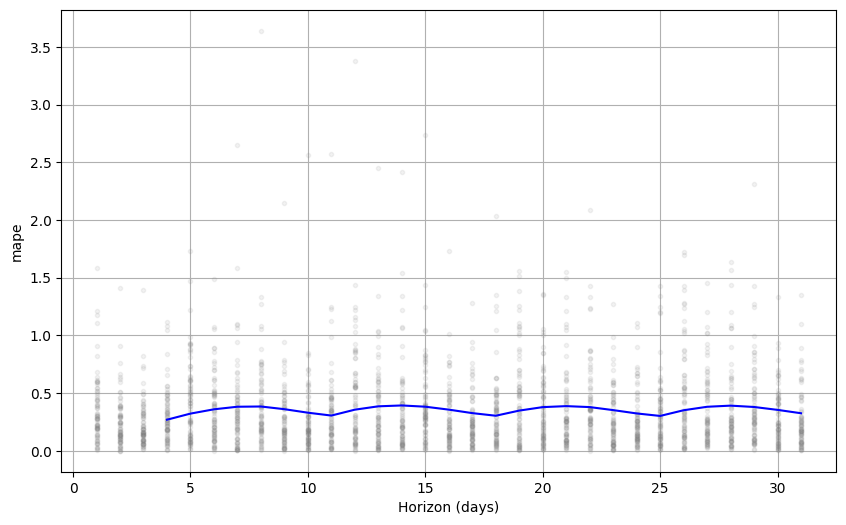

In [74]:
plot_cross_validation_metric(cv_results, metric='mape');

## Total Prediction (no train test split, _"split=1"_)

In [75]:
# total_Shops_Number_sales
prophet_total_shops_sales = prophet_model(
    total_sales,
    split=1
)

# total_Shops_Values
prophet_total_shops_values = prophet_model(
    total_values,
    split=1
)

09:13:31 - cmdstanpy - INFO - Chain [1] start processing
09:13:31 - cmdstanpy - INFO - Chain [1] done processing
09:13:32 - cmdstanpy - INFO - Chain [1] start processing
09:13:32 - cmdstanpy - INFO - Chain [1] done processing


In [76]:
total_sales_pred = get_forecast_data(prophet_total_shops_sales)
total_values_pred = get_forecast_data(prophet_total_shops_values)

### Prediction (sales and values) for "only" the next month, all shops

In [77]:
# SALES
total_sales_pred = total_sales_pred['month']['yhat'][0]
total_sales_pred

2091.6

In [78]:
# VALUES
total_values_pred = total_values_pred['month']['yhat'][0]
total_values_pred

3225336.29

##  Shop Prediction

### Save and Load Models functions

In [242]:
# Save models to file, json(gz) and pickle
def save_model_data(prophet: dict, name: str, save=True):
    """
    Input is the prophet dict return of the prophet_model function.
    name: name of the file to be saved, in .json
    save: save the results in a external file
    Convert Prophet model to json file.
    Convert Data Frame to json file.
    Saves the model and all the data in the local /raw_data/prophet of the project
    Saves only the model in the /prophet_models, local and git repository.
    """
    if not save:
        return "=== MODEL NOT SAVED ==="
    
    print("=== START ===")
    model = {}
    forecast = {}
    train = {}
    test = {}
    horizon = {}
    
    # loop over the ids and features to build a dict with json files
    for id in prophet:
        model[id] = prophet[id]['model']
        forecast[id] = prophet[id]['forecast'].copy()
        train[id] = prophet[id]['train'].copy()
        test[id] = prophet[id]['test'].copy()
        horizon[id] = int(prophet[id]['horizon'])
        
        # prophet model to json
        model[id] = model_to_json(model[id])
              
        # DF to json
        forecast[id] = forecast[id].to_json()
        train[id] = train[id].to_json()
        test[id] = test[id].to_json()
        # horizon[id] = prophet[id]
    
    # save model and data localy
    with gzip.open('../raw_data/prophet/' + name + '_model.gz', 'wt') as model_dict:
        json.dump(model, model_dict)
        
    with gzip.open('../raw_data/prophet/' + name + '_forecast.gz', 'wt') as forecast_dict:
        json.dump(forecast, forecast_dict)
        
    with gzip.open('../raw_data/prophet/' + name + '_train.gz', 'wt') as train_dict:
        json.dump(train, train_dict)
        
    with gzip.open('../raw_data/prophet/' + name + '_test.gz', 'wt') as test_dict:
        json.dump(test, test_dict)
        
    with open('../raw_data/prophet/' + name + '_horizon.pkl', 'wb') as horizon_pkl:
        pickle.dump(horizon, horizon_pkl)
    
    print("=== MODEL SAVED ===")
    
    return None

In [243]:
# Load models from file
def load_model(file_name: str, path='../raw_data/prophet/') -> dict:    
    path_model = os.path.join(path, file_name + "_model.gz")
    path_forecast = os.path.join(path, file_name + "_forecast.gz")
    path_train = os.path.join(path, file_name + "_train.gz")
    path_test = os.path.join(path, file_name + "_test.gz")
    path_horizon = os.path.join(path, file_name + "_horizon.pkl")

    with gzip.open(path_model, 'rt') as mdl:
        model = json.load(mdl)
            
    with gzip.open(path_forecast, 'rt') as frct:
        forecast = json.load(frct)
            
    with gzip.open(path_train, 'rt') as trn:
        train = json.load(trn)
        
    with gzip.open(path_test, 'rt') as tst:
        test = json.load(tst)
            
    with open(path_horizon, 'rb') as hrzn:
        horizon = pickle.load(hrzn)        
    
    results = {}
    for id in model:
        prophet_dict = {}
        prophet_dict = {
            'model': fix_model_from_json(model[id]),
            'forecast': pd.read_json(forecast[id]),
            'train': pd.read_json(train[id]),
            'test': pd.read_json(test[id]),
            'horizon': int(horizon[id]) #HARD CODED! why? no ideia.
        }
        prophet_dict['forecast']['ds'] = pd.to_datetime(prophet_dict['forecast'].ds, unit='ms')
        prophet_dict['train']['ds'] = pd.to_datetime(prophet_dict['train'].ds, unit='ms')
        prophet_dict['test']['ds'] = pd.to_datetime(prophet_dict['test'].ds, unit='ms')
        results[id] = prophet_dict
    
    return results

In [81]:
# Rum prophet or load model result
def run_load_model(df, load=False, model_name="", freq='d'):
    df_id_list = df.columns.to_list()
    prophet_id = {}    
    
    if load:
        print("=== START LOADING ===")
        models = load_model(model_name)
        
        print("=== MODEL LOADED ===")
        
        return models
    
    print("=== Running Prophet Model from Scratch ===")
    
    """
    for id in df_id_list:
        df_ids = df[id].fillna(0)
        prophet_result = prophet_model(
            df=df_ids,
            split=1
        )
        prophet_id[id] = prophet_result
    """
        
    with Pool(cpu_count()) as pool:
        prophet_id = list(pool.map(prophet_model, [df[id].fillna(0) for id in df]))
        
    prophet_id = dict(zip(df_id_list, prophet_id))
    
    print("=== END RUNNING ===")
    
    return prophet_id

### Sales

In [100]:
print(f"LOADED => {LOADED}", f"SAVED => {SAVED}", sep='\n')

LOADED => True
SAVED => False


In [245]:
%%time
# initialize model for each shop id
prophet_shops_id_sales = run_load_model(
    df=shops_sales,
    load=LOADED,
    model_name="prophet_shops_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1.81 s, sys: 2.72 ms, total: 1.81 s
Wall time: 1.81 s


In [246]:
# get the prediction for "only" the next month for every shop
shops_id_sales_pred = {}
for shop in prophet_shops_id_sales:
    pred = prophet_shops_id_sales[shop]
    pred = get_forecast_data(pred)
    shops_id_sales_pred[shop] = pred['month']['yhat'][0]

In [194]:
indice = prophet_shops_id_sales['shop_id_0']['forecast']['ds']

In [195]:
prophet_shops_id_sales['shop_id_0']['forecast']['yhat']

0       103.651024
1        99.428523
2       141.383283
3       216.917496
4       282.966388
           ...    
1091      0.051890
1092      0.055844
1093      0.053042
1094      0.081975
1095      0.135032
Name: yhat, Length: 1096, dtype: float64

In [196]:
xxx = pd.DataFrame(index=indice)
for id in prophet_shops_id_sales:
    xxx[id] = list(prophet_shops_id_sales[id]['forecast']['yhat'])
xxx

shop_id_0   shop_id_1  shop_id_2  shop_id_3   shop_id_4  \
ds                                                                     
2013-01-01  103.651024   60.797061  56.824124  44.875478  109.475343   
2013-01-02   99.428523   47.807170  53.793622  43.271748  107.353853   
2013-01-03  141.383283   96.237167  50.475763  44.601411  101.114275   
2013-01-04  216.917496   78.171848  54.307148  47.575752  110.383107   
2013-01-05  282.966388  168.344487  60.204855  59.770672  125.395817   
...                ...         ...        ...        ...         ...   
2015-12-28    0.051890    0.004454  50.633235  34.719554   53.969261   
2015-12-29    0.055844    0.005465  56.411046  36.074077   56.673188   
2015-12-30    0.053042    0.004322  54.553215  35.587245   56.624259   
2015-12-31    0.081975    0.008352  52.388559  37.418177   54.483183   
2016-01-01    0.135032    0.006732  57.002503  40.521946   59.985458   

            shop_id_5   shop_id_6   shop_id_7   shop_id_8  shop_id_9  ...  \
ds                                                                    ...   
2013-01-01  22.313620  198.868969  148.465672   93.451017   9.393606  ...   
2013-01-02  21.767259  182.720826  139.349230   91.346499  11.747120  ...   
2013-01-03  22.590207  182.002033  138.568964   83.523007   6.216537  ...   
2013-01-04  24.512652  197.526931  143.939708   87.146286  -8.282167  ...   
2013-01-05  31.064531  215.775080  167.528323  119.597451 -12.709252  ...   
...               ...         ...         ...         ...        ...  ...   
2015-12-28  47.455034   69.604646   84.701135    0.025558 -11.752375  ...   
2015-12-29  47.846075   72.655807   85.975848    0.023183  -4.124657  ...   
2015-12-30  46.583320   68.089884   82.626285    0.022889   3.436722  ...   
2015-12-31  48.096466   68.516408   83.758009    0.021462  -8.099461  ...   
2016-01-01  51.642381   74.157115   88.128337    0.021975 -42.620823  ...   

            shop_id_50  shop_id_51  shop_id_52  shop_id_53  shop_id_54  \
ds                                                                       
2013-01-01  167.960042  124.856831   96.605599  115.136729  448.075116   
2013-01-02  164.973417  124.442609   91.279905  109.476480  456.992281   
2013-01-03  167.849530  120.047592   89.781614  108.305646  453.540338   
2013-01-04  174.278123  128.962235   97.550371  112.134103  485.963396   
2013-01-05  216.160192  156.402221  106.294133  141.457338  696.739723   
...                ...         ...         ...         ...         ...   
2015-12-28   32.243468   11.336935   48.344877   52.557644 -293.230438   
2015-12-29   31.901658   11.617664   49.865779   54.764919 -300.168832   
2015-12-30   31.819238   11.662010   48.035998   53.138574 -314.033904   
2015-12-31   32.753900   11.346556   48.046573   53.516262 -319.711524   
2016-01-01   34.272556   12.150832   52.543326   56.097867 -348.192504   

            shop_id_55  shop_id_56  shop_id_57  shop_id_58  shop_id_59  
ds                                                                      
2013-01-01   -1.911387  165.158095    5.171309    7.252960  100.600291  
2013-01-02   -1.689175  161.989780    8.022340    8.765721   96.364805  
2013-01-03   -1.600556  163.749165   10.588200   10.061991   98.123504  
2013-01-04   -1.396188  183.408422   14.489007   11.774192  102.223931  
2013-01-05   -1.250992  239.761532   19.979622   15.204923  136.079006  
...                ...         ...         ...         ...         ...  
2015-12-28  117.470560   48.641568   85.093934   91.003646   55.348432  
2015-12-29  134.570488   50.020232   87.923066   89.451560   57.416784  
2015-12-30  135.754736   49.964253   86.366447   88.648741   56.193664  
2015-12-31  151.791627   51.347953   84.228868   86.783360   58.117291  
2016-01-01  158.337191   57.979586   90.853579   88.292622   61.209388  

[1096 rows x 60 columns]

<AxesSubplot: xlabel='ds', ylabel='shop_id_2'>

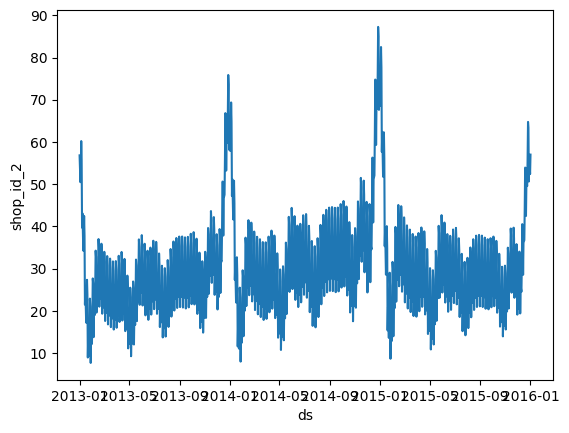

In [197]:
sns.lineplot(xxx['shop_id_2'])

<font size="5"> Total Sales for next month, sun of all shops </font>

In [247]:
all_shops_id_sales_pred = sum(list(shops_id_sales_pred.values()))
all_shops_id_sales_pred

1946.6799999999998

#### Save the data (on _raw\_data_) and model (on _git_) in json file

In [252]:
save_model_data(prophet_shops_id_sales, 'prophet_shops_id_sales', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot example

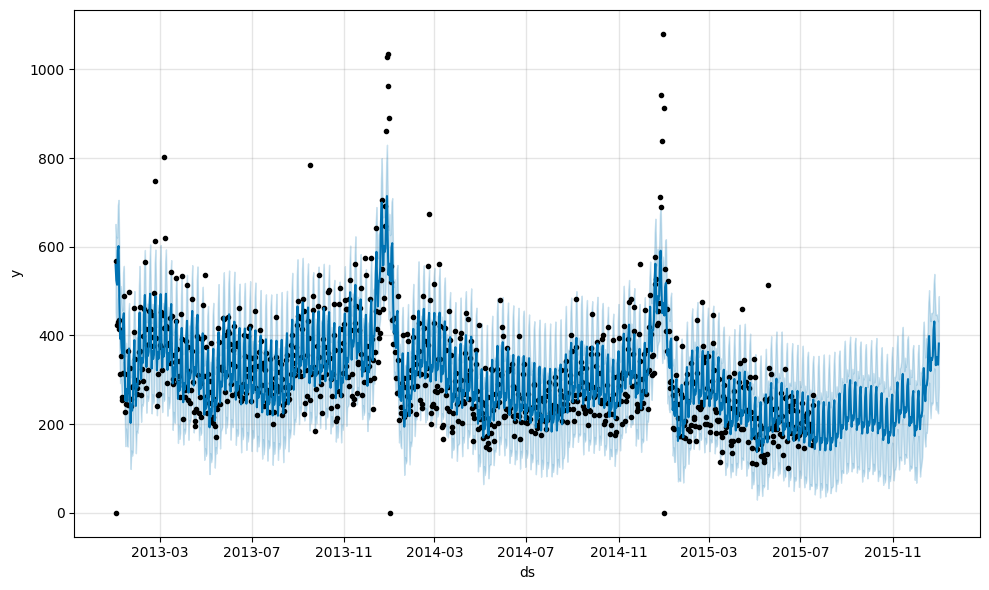

In [248]:
prophet_shops_id_sales['shop_id_31']['model'].plot(prophet_shops_id_sales['shop_id_31']['forecast']);

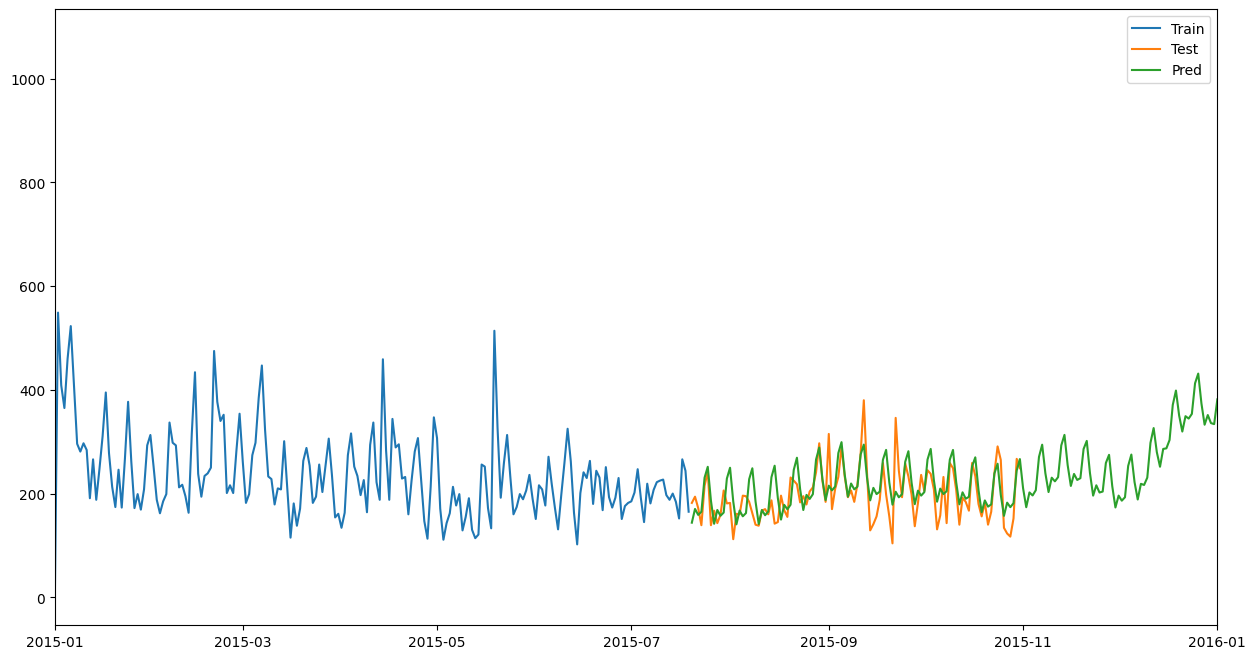

In [250]:
plot_forecast(prophet_shops_id_sales['shop_id_31'], left='2015-01', right='2016-01')

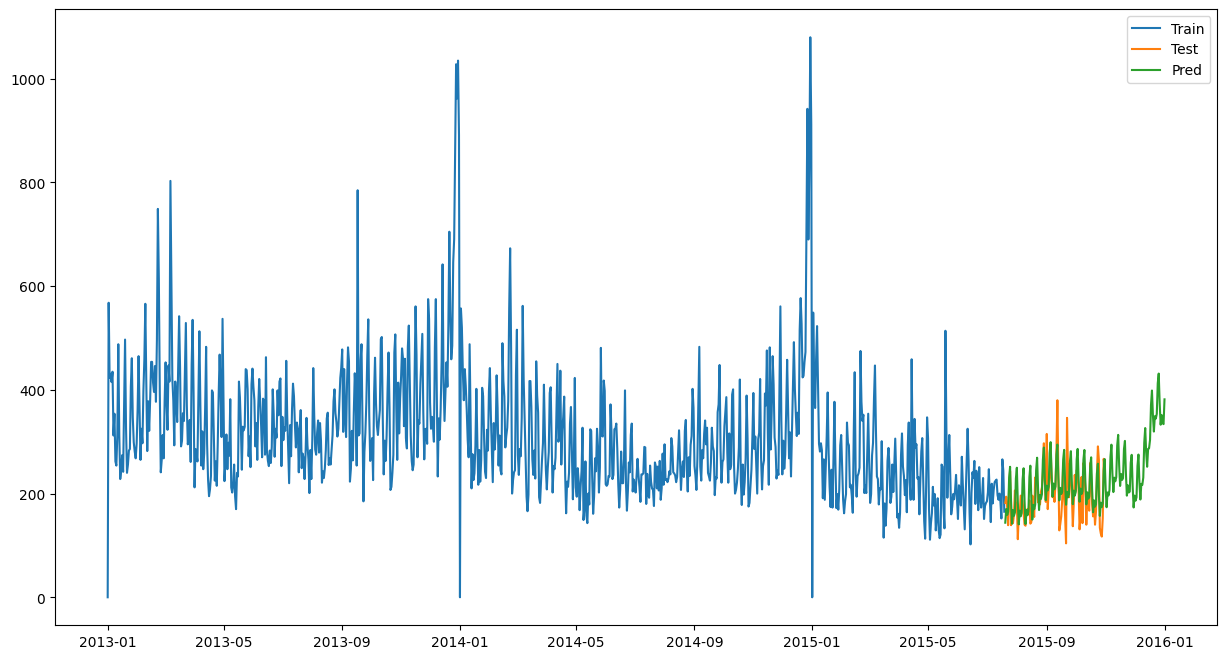

In [251]:
plot_forecast(prophet_shops_id_sales['shop_id_31'])

### Values

In [260]:
%%time
# initialize model for each shop id
prophet_shops_id_values = run_load_model(
    df=shops_values,
    load=LOADED,
    model_name="prophet_shops_id_values",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1.96 s, sys: 11 ms, total: 1.98 s
Wall time: 1.97 s


In [262]:
# get the prediction for "only" the next month for every shop
shops_id_values_pred = {}
for shop in prophet_shops_id_values:
    pred = prophet_shops_id_values[shop]
    pred = get_forecast_data(pred)
    shops_id_values_pred[shop] = pred['month']['yhat'][0]

<font size="5"> Total Values for next month, sun of all shops </font>

In [263]:
all_shops_id_values_pred = sum(list(shops_id_values_pred.values()))
all_shops_id_values_pred

3353006.3099999987

#### Save the data (on raw_data) and model (on git) in json file

In [261]:
save_model_data(prophet_shops_id_values, 'prophet_shops_id_values', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot example

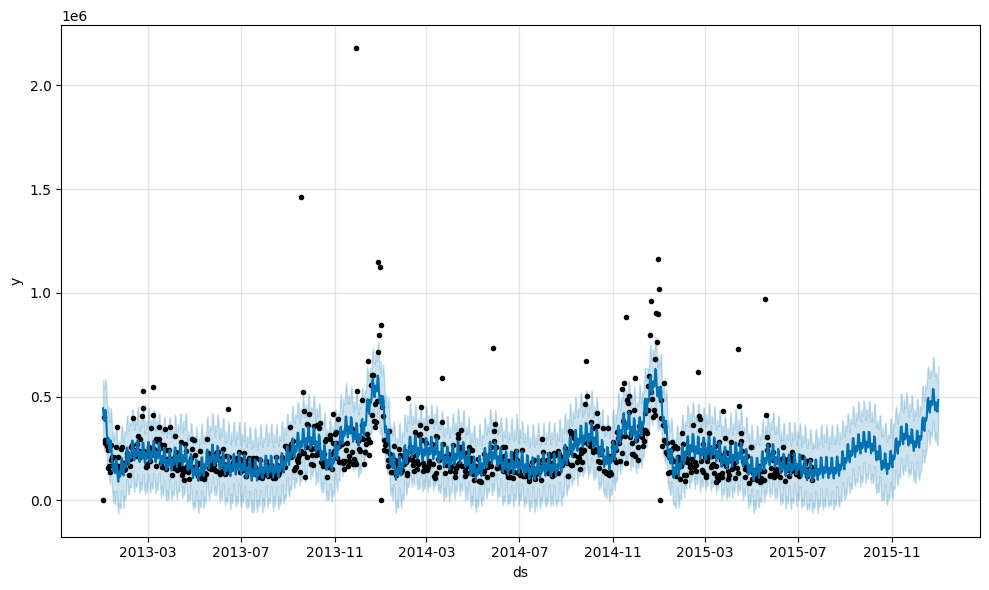

In [264]:
prophet_shops_id_values['shop_id_31']['model'].plot(prophet_shops_id_values['shop_id_31']['forecast']);

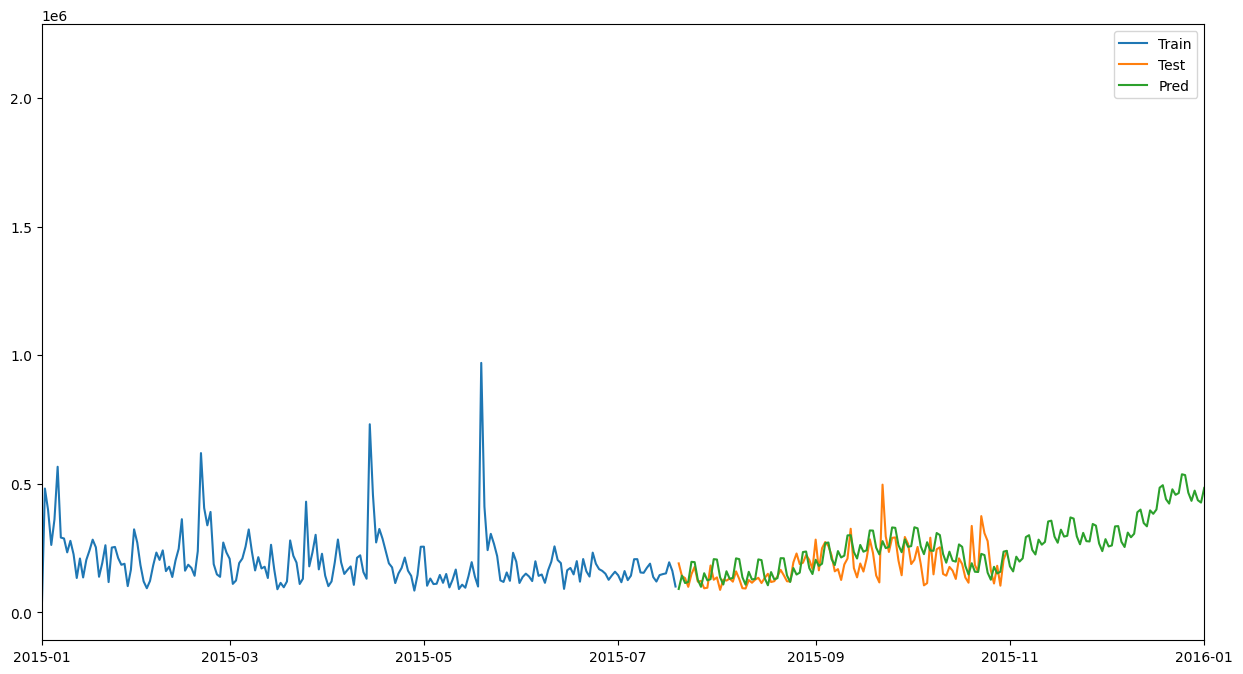

In [266]:
plot_forecast(prophet_shops_id_values['shop_id_31'], left='2015-01', right='2016-01')

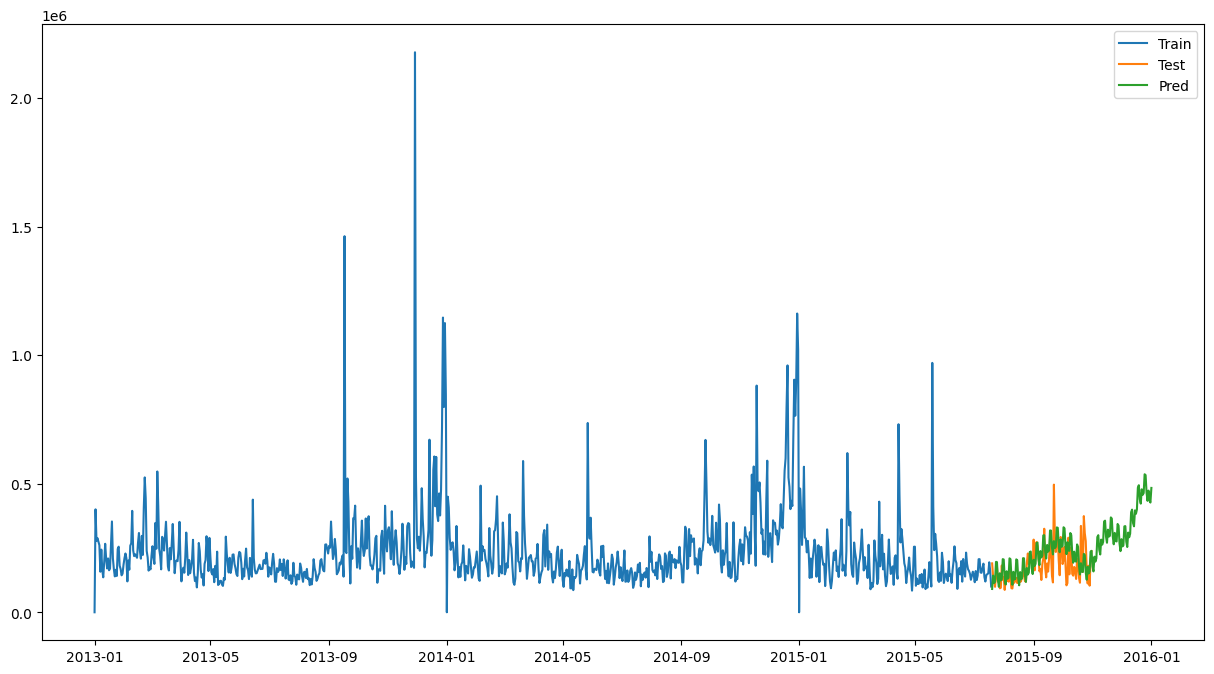

In [265]:
plot_forecast(prophet_shops_id_values['shop_id_31'])

## Category Prediction

### Sales

In [287]:
%%time
# initialize model for each category id
prophet_cats_id_sales = run_load_model(
    df=cats_sales,
    load=LOADED,
    model_name="prophet_cats_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 2.72 s, sys: 26.3 ms, total: 2.75 s
Wall time: 2.74 s


In [289]:
# get the prediction for "only" the next month for every category
cats_id_sales_pred = {}
for cat in prophet_cats_id_sales:
    pred = prophet_cats_id_sales[cat]
    pred = get_forecast_data(pred)
    cats_id_sales_pred[cat] = pred['month']['yhat'][0]

<font size="5"> Total Sales for next month, sun of all categories </font>

In [290]:
all_cats_id_sales_pred = sum(list(cats_id_sales_pred.values())).round(2)
all_cats_id_sales_pred

2214.7

#### Save the data (on raw_data) and model (on git) in json file

In [288]:
save_model_data(prophet_cats_id_sales, 'prophet_cats_id_sales', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot Example

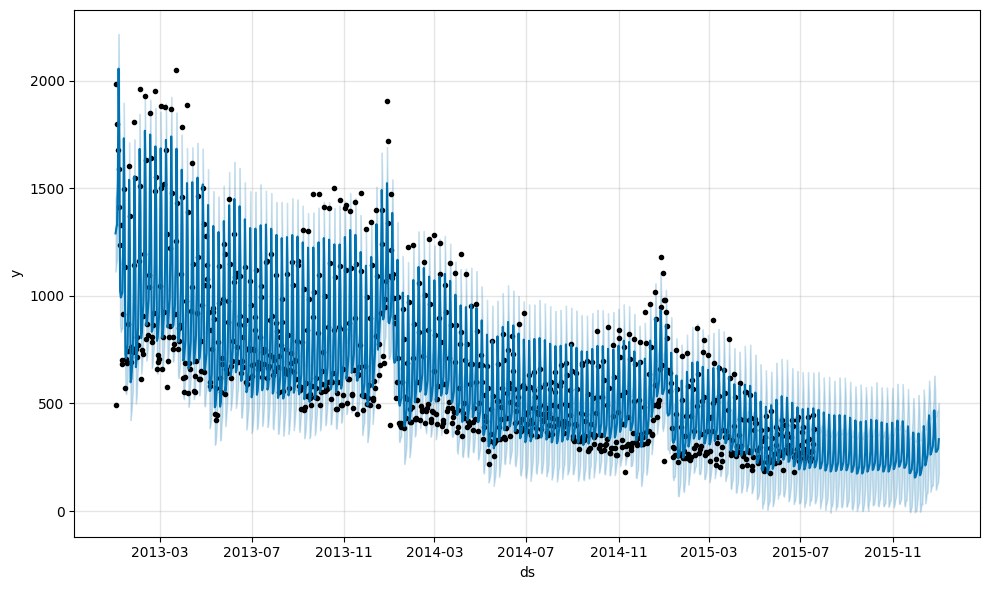

In [291]:
prophet_cats_id_sales['cat_id_40']['model'].plot(prophet_cats_id_sales['cat_id_40']['forecast']);

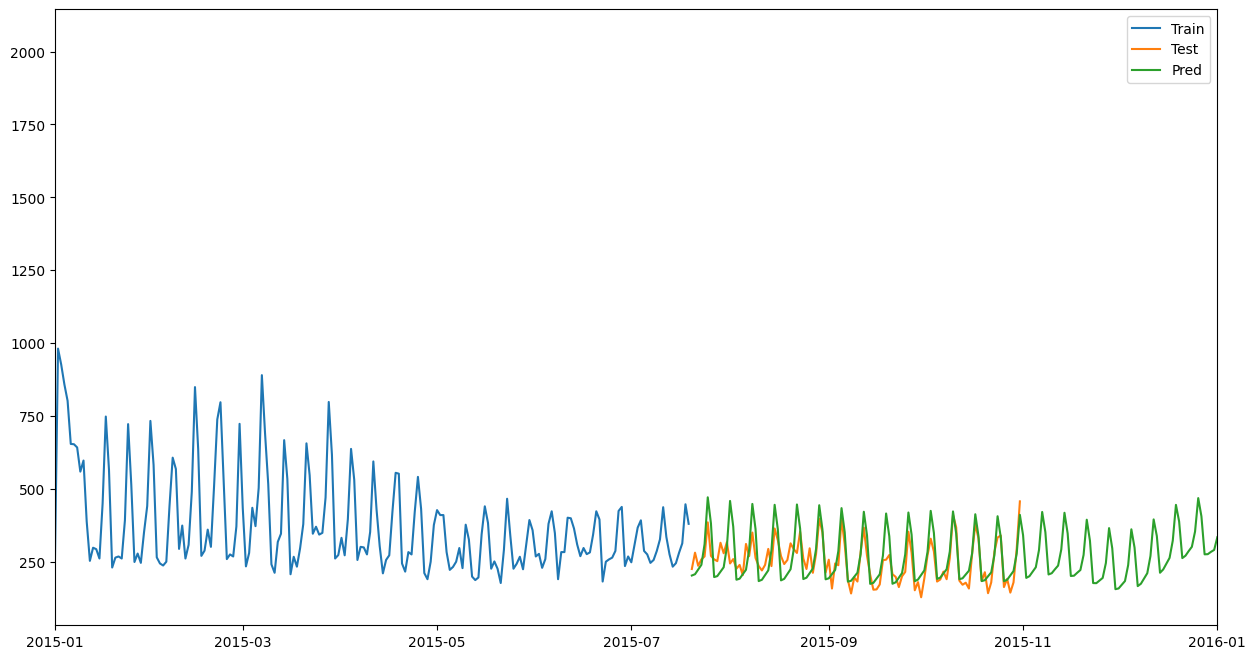

In [292]:
plot_forecast(prophet_cats_id_sales['cat_id_40'], left='2015-01', right='2016-01')

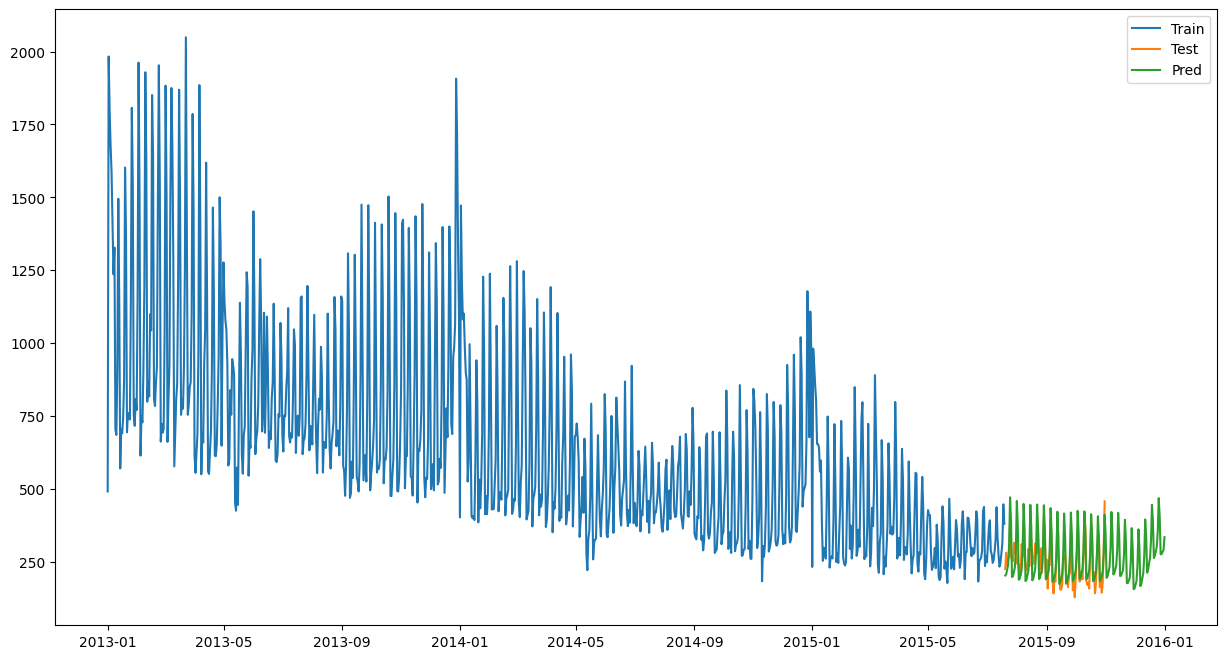

In [293]:
plot_forecast(prophet_cats_id_sales['cat_id_40'])

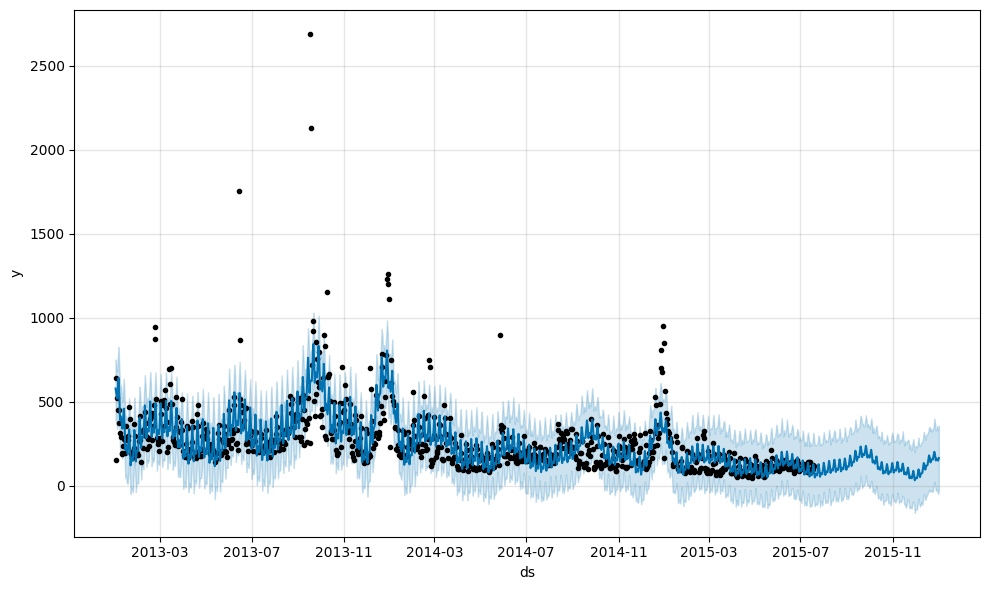

In [294]:
prophet_cats_id_sales['cat_id_19']['model'].plot(prophet_cats_id_sales['cat_id_19']['forecast']);

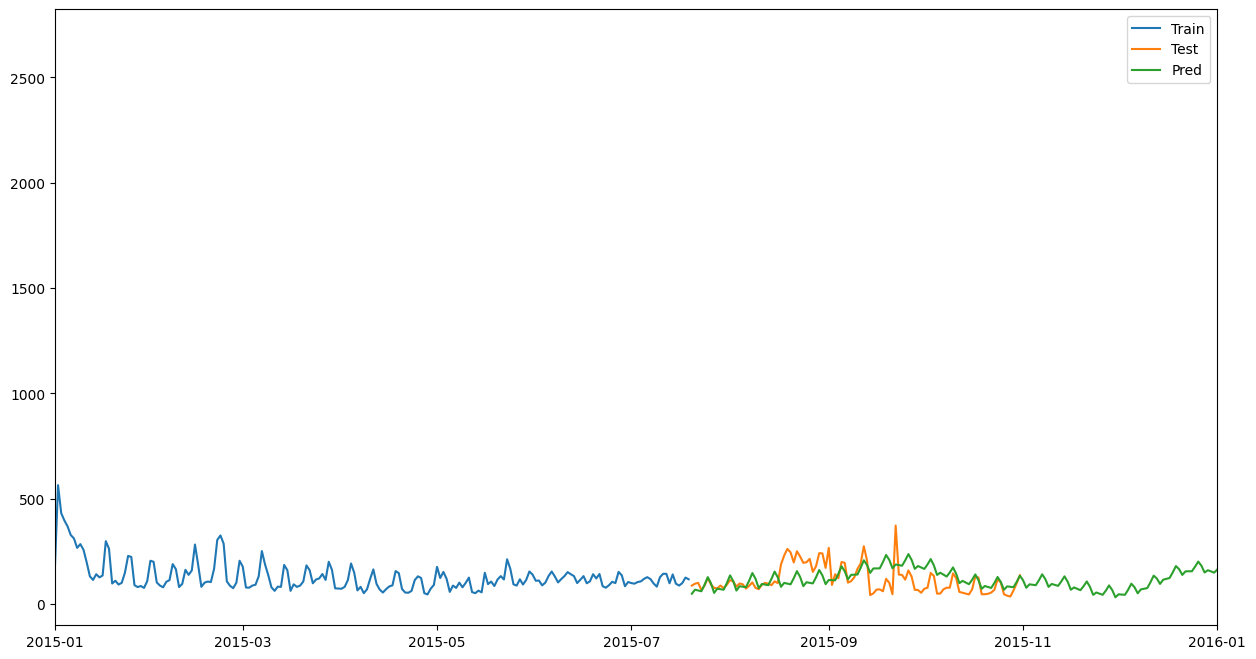

In [295]:
plot_forecast(prophet_cats_id_sales['cat_id_19'], left='2015-01', right='2016-01')

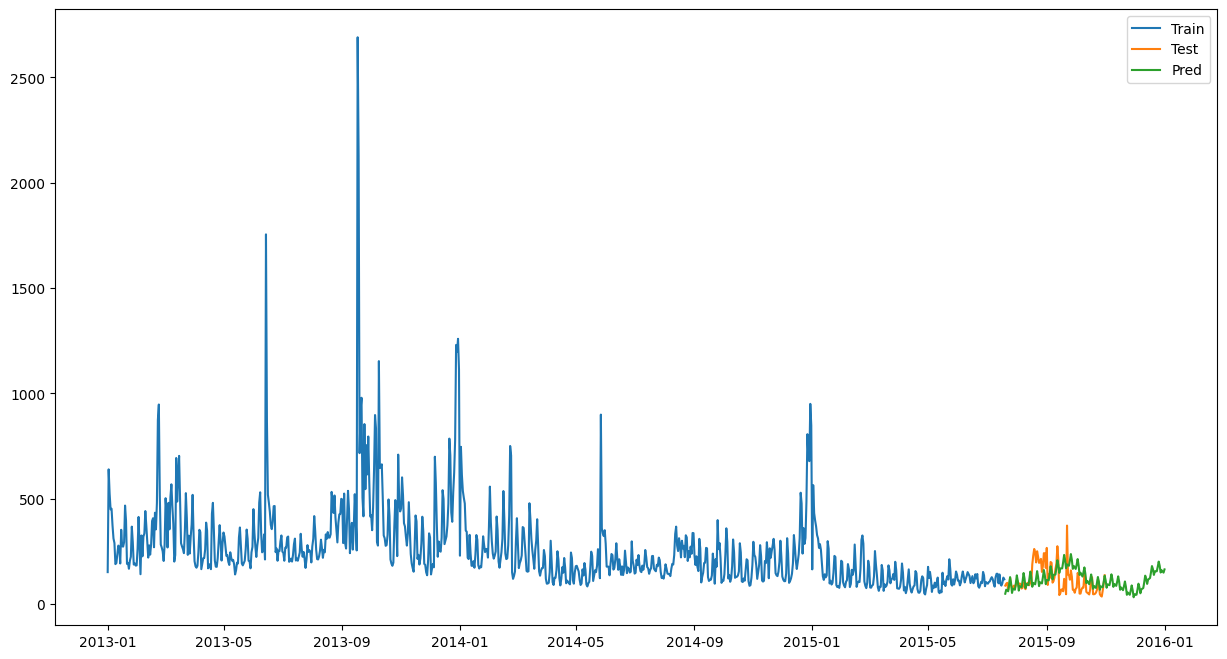

In [296]:
plot_forecast(prophet_cats_id_sales['cat_id_19'])

### Values

In [308]:
%%time
# initialize model for each category id
prophet_cats_id_values = run_load_model(
    df=cats_values,
    load=LOADED,
    model_name="prophet_cats_id_values",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 2.5 s, sys: 30.6 ms, total: 2.53 s
Wall time: 2.53 s


In [309]:
# get the prediction for "only" the next month for every category
cats_id_values_pred = {}
for cat in prophet_cats_id_values:
    pred = prophet_cats_id_values[cat]
    pred = get_forecast_data(pred)
    cats_id_values_pred[cat] = pred['month']['yhat'][0]

<font size="5"> Total Values for next month, sun of all categories </font>

In [310]:
all_cats_id_values_pred = sum(list(cats_id_values_pred.values())).round(2)
all_cats_id_values_pred

4456207.35

#### Save the data (on raw_data) and model (on git) in json file

In [307]:
save_model_data(prophet_cats_id_values, 'prophet_cats_id_values', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot Example

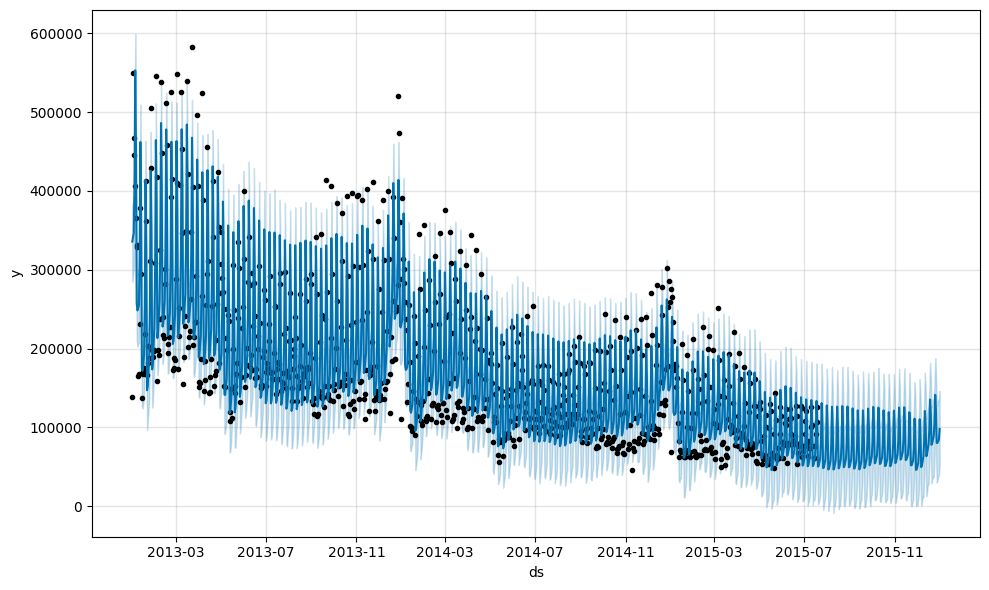

In [311]:
prophet_cats_id_values['cat_id_40']['model'].plot(prophet_cats_id_values['cat_id_40']['forecast']);

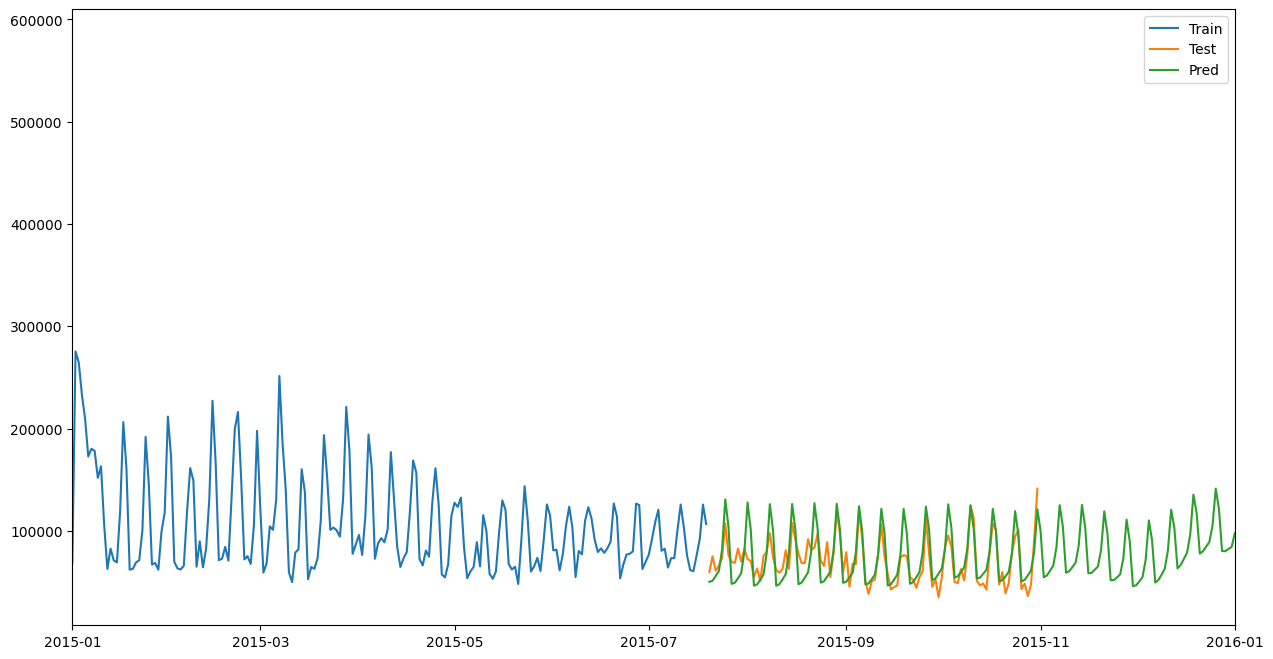

In [312]:
plot_forecast(prophet_cats_id_values['cat_id_40'], left='2015-01', right='2016-01')

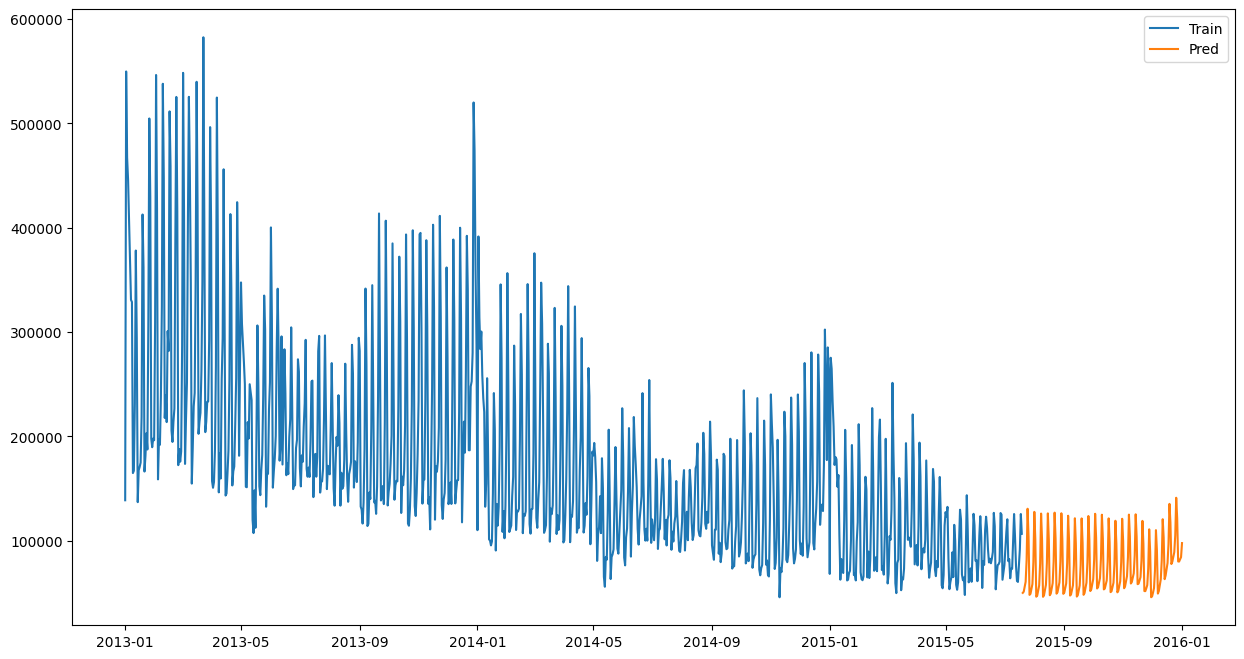

In [313]:
plot_forecast(prophet_cats_id_values['cat_id_40'], test=False)

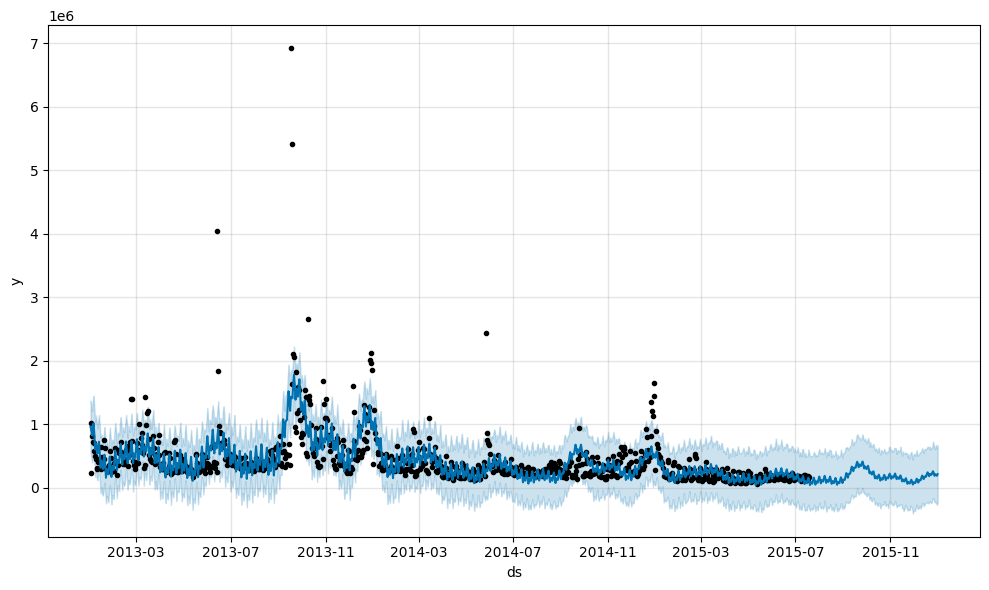

In [314]:
prophet_cats_id_values['cat_id_19']['model'].plot(prophet_cats_id_values['cat_id_19']['forecast']);

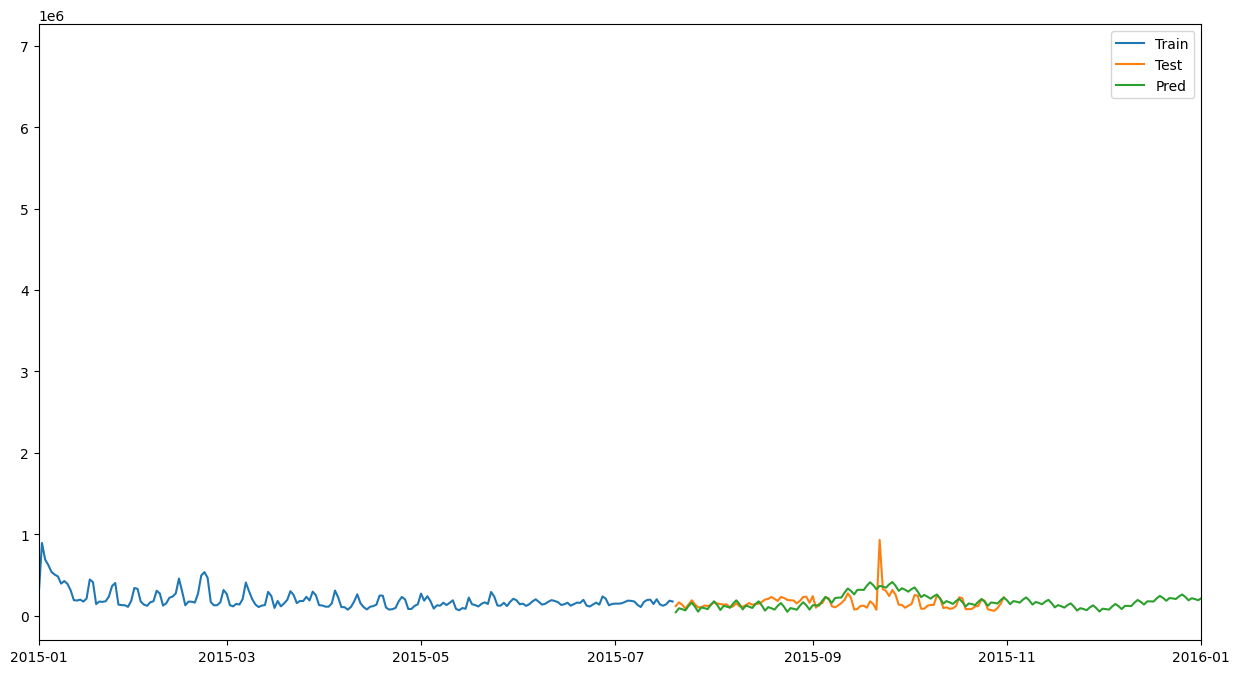

In [315]:
plot_forecast(prophet_cats_id_values['cat_id_19'], left='2015-01', right='2016-01')

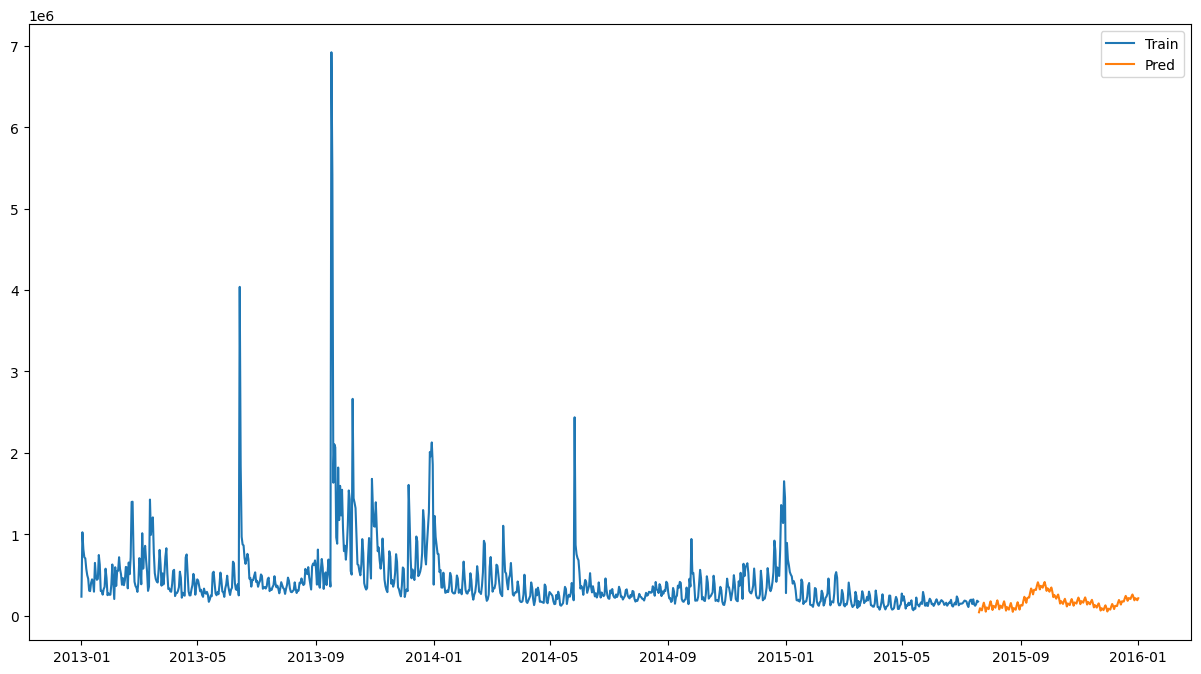

In [316]:
plot_forecast(prophet_cats_id_values['cat_id_19'], test=False)

## Item Prediction

### Sales

In [112]:
%%time
# initialize model for each category id
prophet_items_id_sales = run_load_model(
    df=items_sales,
    load=LOADED,
    model_name="prophet_items_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 1min 56s, sys: 2.43 s, total: 1min 59s
Wall time: 1min 59s


In [139]:
# get the prediction for "only" the next month for every item
items_id_sales_pred = {}
for item in prophet_items_id_sales:
    pred = prophet_items_id_sales[item]
    pred = get_forecast_data(pred)
    items_id_sales_pred[item] = pred['month']['yhat'][0]

In [144]:
items_id_sales_pred

{'30': 0.02,
 '31': 0.49,
 '32': 0.9,
 '33': 0.18,
 '38': 0.13,
 '42': 0.0,
 '45': 0.09,
 '51': 0.03,
 '53': 0.08,
 '57': 0.1,
 '59': 0.07,
 '62': -0.05,
 '64': -0.03,
 '67': 0.36,
 '69': 0.57,
 '70': 0.41,
 '72': -0.01,
 '76': -0.04,
 '80': 0.0,
 '88': -0.01,
 '91': 0.27,
 '93': 0.1,
 '109': 0.06,
 '138': -0.01,
 '149': 0.11,
 '153': 0.03,
 '154': 0.08,
 '166': 0.01,
 '180': 0.02,
 '202': 0.07,
 '205': 0.12,
 '213': 0.1,
 '226': 0.03,
 '234': 0.16,
 '248': 0.28,
 '253': 0.03,
 '259': 0.04,
 '269': 0.12,
 '308': 0.05,
 '313': 0.03,
 '315': 0.28,
 '325': 0.1,
 '342': 0.0,
 '353': 0.05,
 '356': 0.05,
 '388': 0.05,
 '407': 0.02,
 '408': 0.0,
 '413': 0.07,
 '421': -0.01,
 '445': 0.02,
 '448': 0.04,
 '464': 0.74,
 '473': 0.24,
 '474': 0.02,
 '477': 0.01,
 '478': 0.01,
 '482': 1.05,
 '486': 6.36,
 '491': 0.23,
 '492': 3.65,
 '494': 0.07,
 '496': 0.04,
 '502': 0.05,
 '503': 0.11,
 '504': 0.08,
 '505': 0.03,
 '508': 0.0,
 '515': 0.15,
 '521': 0.01,
 '524': 0.0,
 '528': -0.0,
 '536': 0.03,
 '53

<font size="5"> Total Sales for next month, sun of all items </font>

In [140]:
all_items_id_sales_pred = sum(list(items_id_sales_pred.values())).round(2)
all_items_id_sales_pred

4097.24

#### Save the data (on raw_data) and model (on git) in json file

In [115]:
save_model_data(prophet_items_id_sales, 'prophet_items_id_sales', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot Example

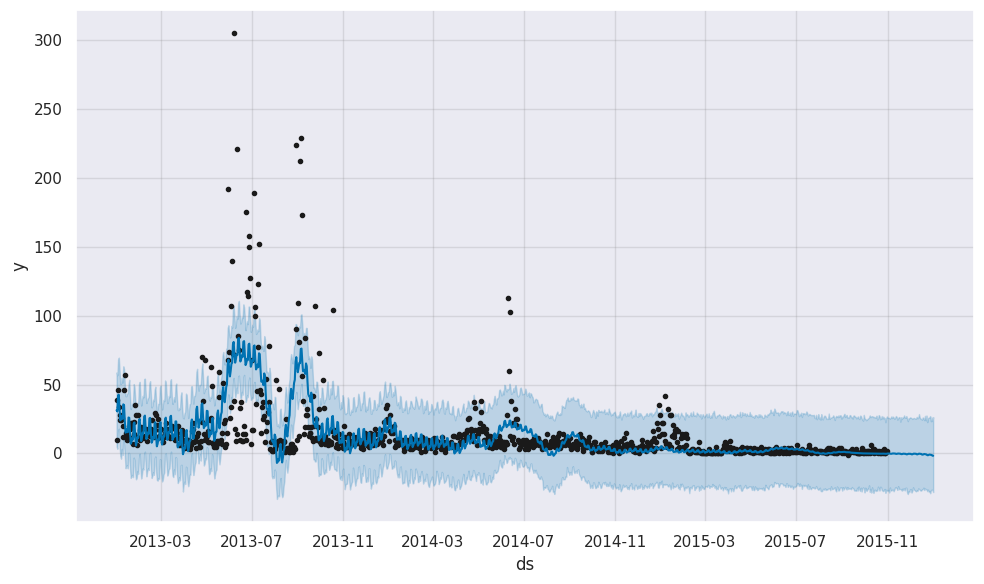

In [116]:
prophet_items_id_sales['2808']['model'].plot(prophet_items_id_sales['2808']['forecast']);

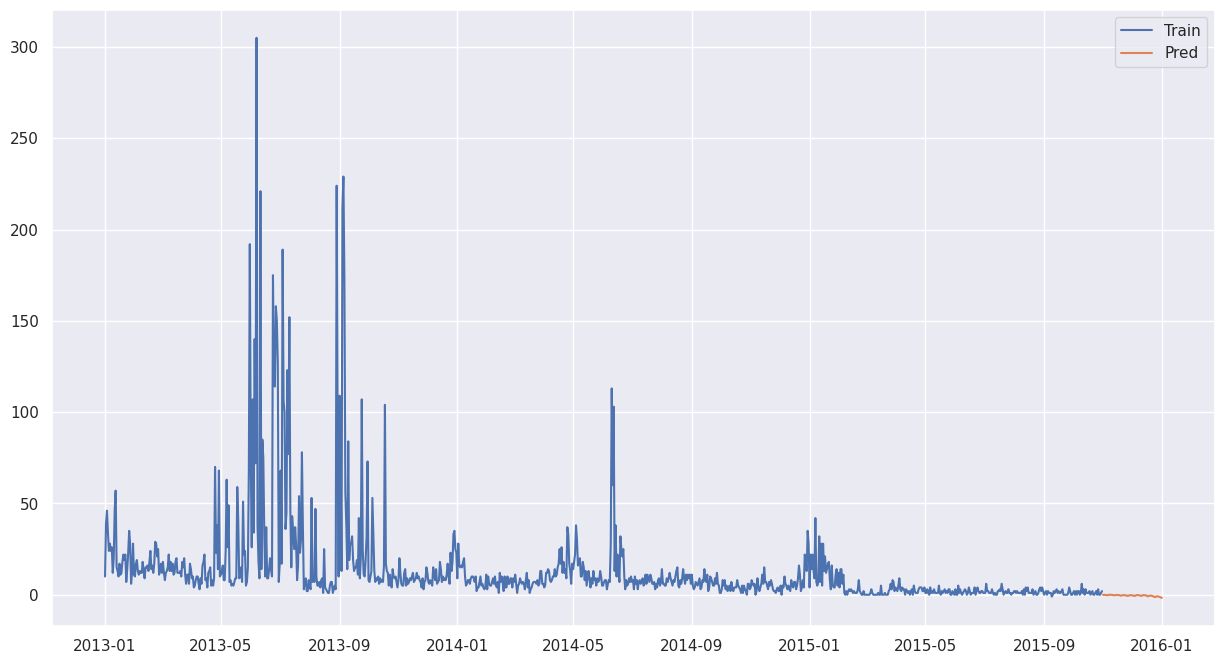

In [117]:
plot_forecast(prophet_items_id_sales['2808'], test=False)

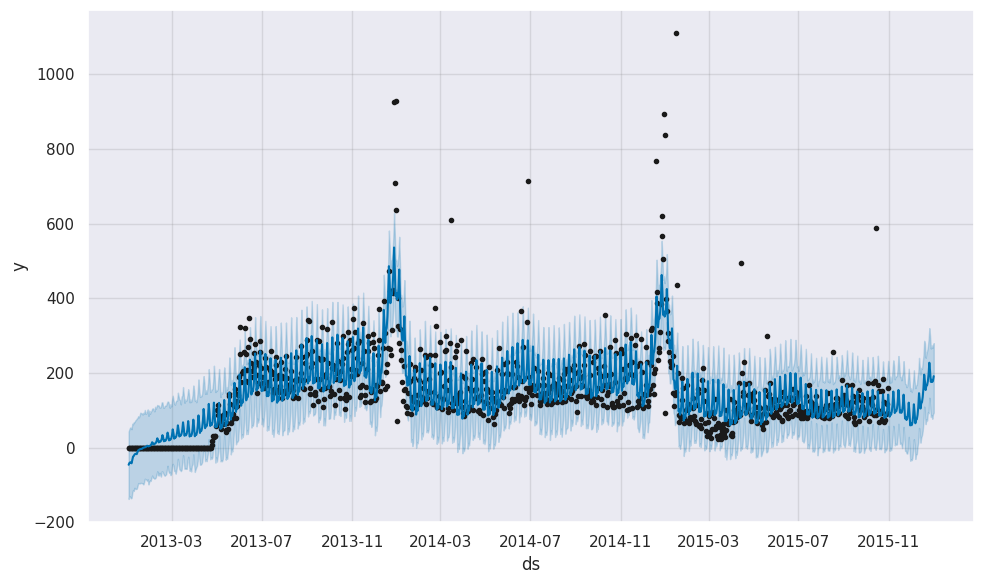

In [118]:
prophet_items_id_sales['20949']['model'].plot(prophet_items_id_sales['20949']['forecast']);

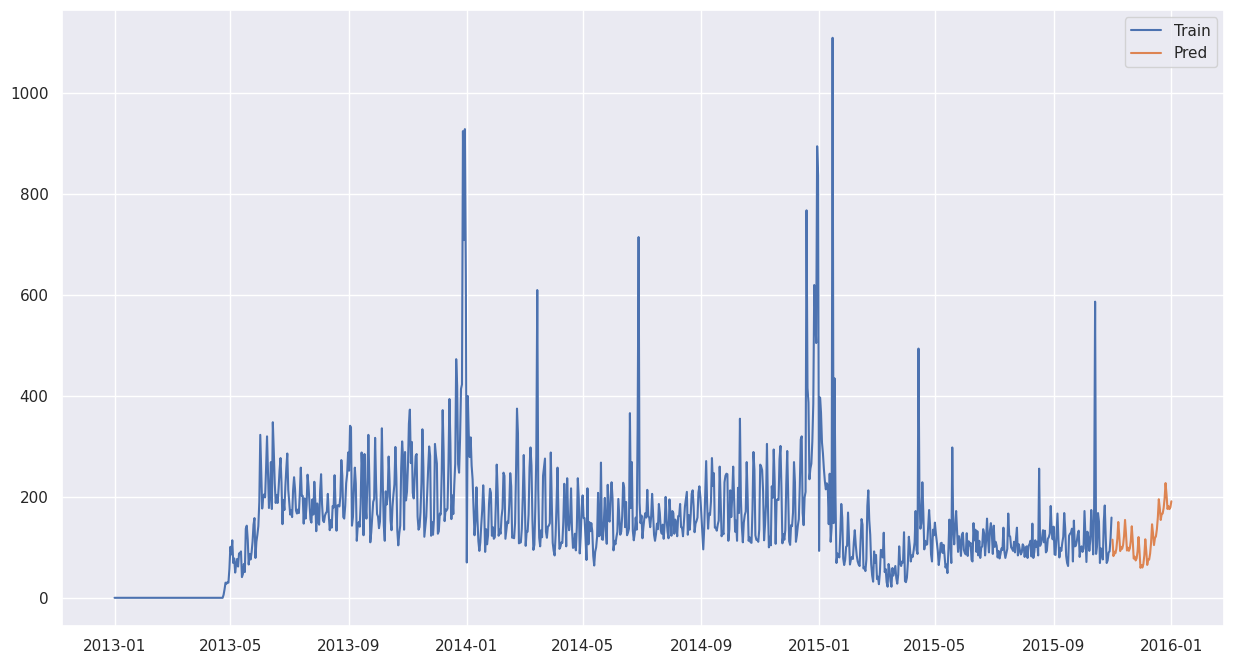

In [119]:
plot_forecast(prophet_items_id_sales['20949'], test=False)

### Values

In [ ]:
%%time
# initialize model for each category id
prophet_items_id_values = run_load_model(
    df=items_values,
    load=False,
    model_name="prophet_items_id_values",
    freq=freq_analysis)

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

## Categories by Shop Prediction

### Sales

In [167]:
%%time
# initialize model for each category id
prophet_cats_shops_id_sales = run_load_model(
    df=cats_shops_sales,
    load=LOADED,
    model_name="prophet_cats_shops_id_sales",
    freq=freq_analysis)

=== START LOADING ===
=== MODEL LOADED ===
CPU times: user 52.7 s, sys: 607 ms, total: 53.3 s
Wall time: 53.3 s


In [168]:
# get the prediction for "only" the next month for every item
cats_shops_id_sales_pred = {}
for item in prophet_cats_shops_id_sales:
    pred = prophet_cats_shops_id_sales[item]
    pred = get_forecast_data(pred)
    cats_shops_id_sales_pred[item] = pred['month']['yhat'][0]

In [169]:
cats_shops_id_sales_pred

{'2-2': 0.04,
 '2-3': 0.32,
 '2-5': 0.01,
 '2-6': 0.1,
 '2-7': 0.16,
 '2-11': 0.0,
 '2-12': 0.0,
 '2-15': 0.04,
 '2-16': 0.0,
 '2-19': 2.58,
 '2-20': 7.67,
 '2-21': 0.14,
 '2-22': 0.19,
 '2-23': 2.13,
 '2-24': 1.1,
 '2-25': 0.3,
 '2-28': 4.15,
 '2-29': 0.24,
 '2-30': 2.59,
 '2-33': 0.11,
 '2-35': 0.24,
 '2-37': 0.94,
 '2-38': 0.76,
 '2-40': 1.27,
 '2-41': 0.04,
 '2-42': 0.48,
 '2-43': 0.0,
 '2-47': 1.83,
 '2-49': -0.0,
 '2-55': -0.11,
 '2-56': 0.08,
 '2-57': -0.0,
 '2-58': 0.01,
 '2-61': 0.11,
 '2-62': 0.0,
 '2-63': 1.02,
 '2-64': 0.41,
 '2-65': 0.42,
 '2-67': 0.04,
 '2-69': 0.45,
 '2-70': 1.52,
 '2-71': -0.0,
 '2-72': 1.38,
 '2-73': 0.07,
 '2-75': 0.26,
 '2-77': 0.0,
 '2-79': 0.18,
 '2-83': 0.0,
 '3-2': 0.23,
 '3-3': 0.56,
 '3-5': 0.0,
 '3-6': 0.2,
 '3-7': 0.13,
 '3-11': 0.01,
 '3-12': 0.09,
 '3-15': 0.01,
 '3-16': 0.0,
 '3-19': 1.22,
 '3-20': 4.86,
 '3-21': 0.18,
 '3-22': 0.1,
 '3-23': 1.53,
 '3-24': 1.06,
 '3-25': 0.07,
 '3-28': 2.03,
 '3-29': 0.01,
 '3-30': 4.36,
 '3-33': 0.25,
 '3

<font size="5"> Total Sales for next month, sun of all items </font>

In [170]:
all_cats_shops_id_sales_pred = sum(list(cats_shops_id_sales_pred.values())).round(2)
all_cats_shops_id_sales_pred

2792.99

#### Save the data (on raw_data) and model (on git) in json file

In [154]:
new_keys = [str(key[0])+"-"+str(key[1]) for key in prophet_cats_shops_id_sales.keys()]
prophet_cats_shops_id_sales_new = dict(zip(new_keys, prophet_cats_shops_id_sales.values()))

In [166]:
save_model_data(prophet_cats_shops_id_sales_new, 'prophet_cats_shops_id_sales', save=SAVED)

'=== MODEL NOT SAVED ==='

#### Plot Example

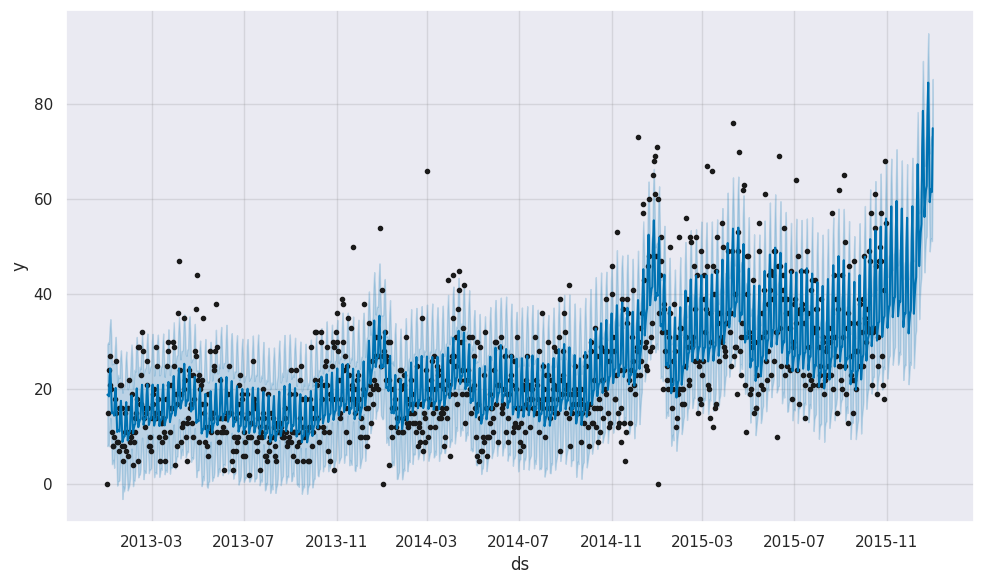

In [172]:
prophet_cats_shops_id_sales_new['31-40']['model'].plot(prophet_cats_shops_id_sales_new['31-40']['forecast']);

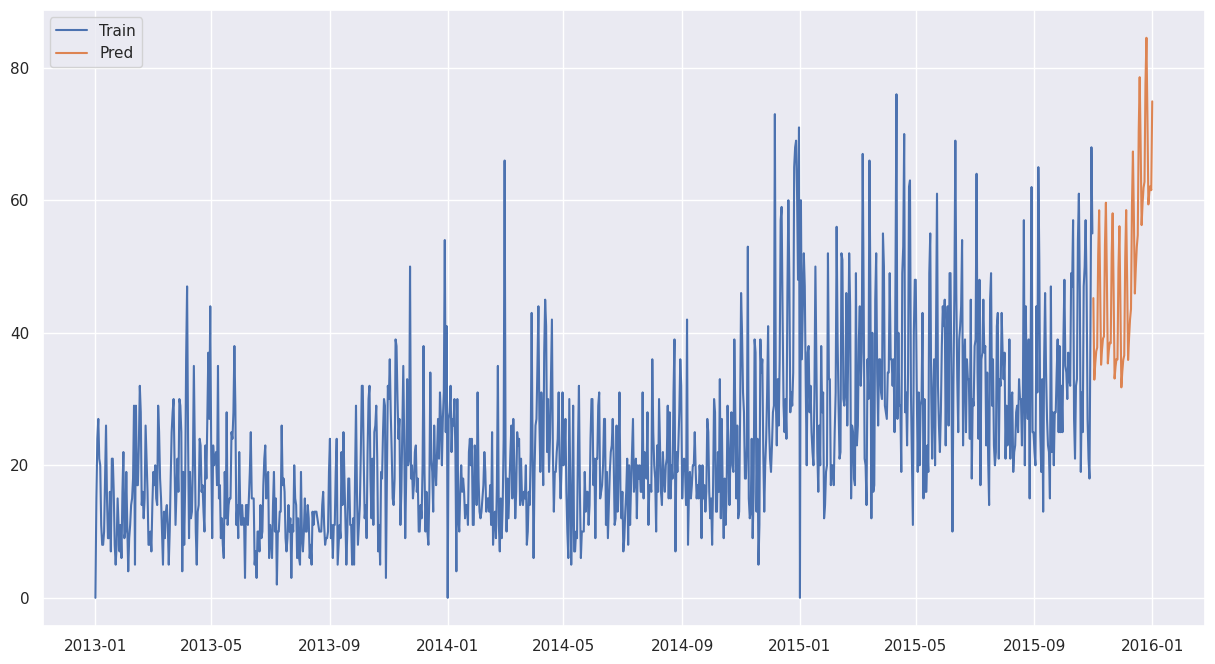

In [173]:
plot_forecast(prophet_cats_shops_id_sales_new['31-40'], test=False)

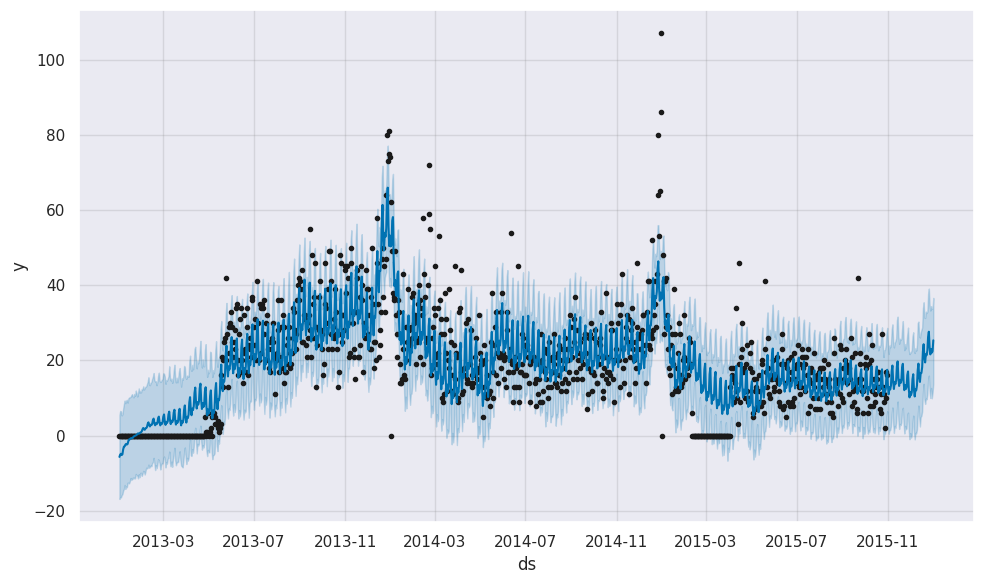

In [174]:
prophet_cats_shops_id_sales_new['31-71']['model'].plot(prophet_cats_shops_id_sales_new['31-71']['forecast']);

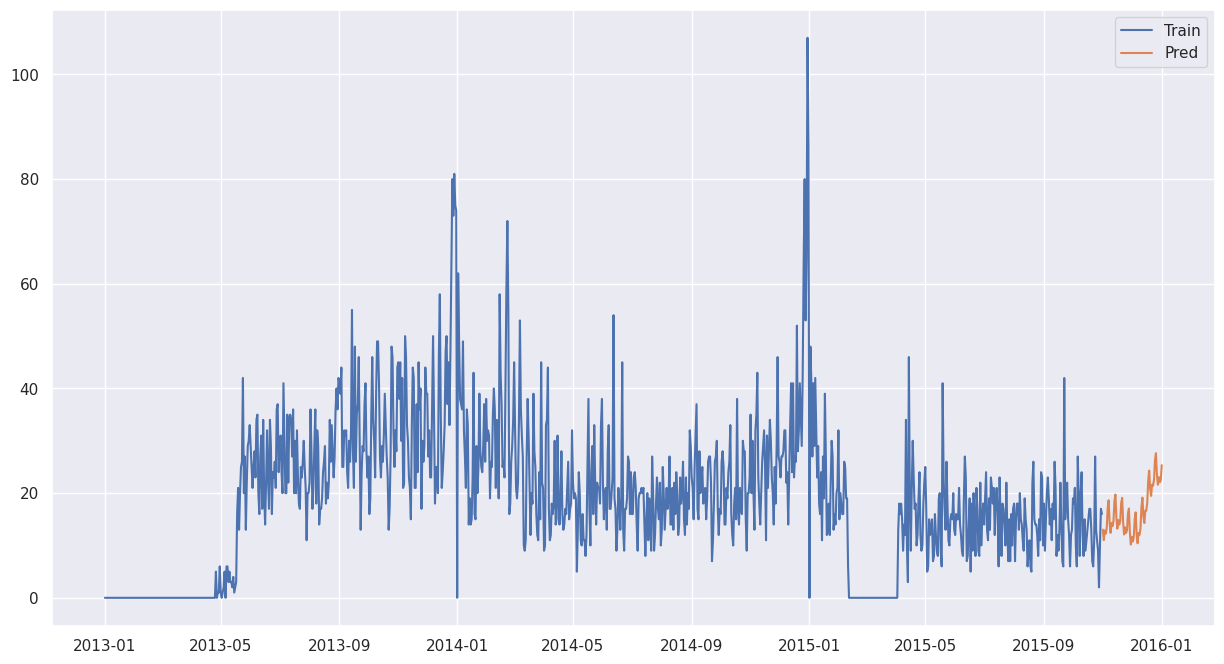

In [175]:
plot_forecast(prophet_cats_shops_id_sales_new['31-71'], test=False)

### Values

<font size="5"> Total Sales for next month, sun of all items </font>

#### Save the data (on raw_data) and model (on git) in json file

#### Plot Example

# Predictions
___

## For all Data Set, the sum of Shops and Category ids

In [181]:
pred_df = pd.DataFrame(
    {'total':[total_sales_pred, total_values_pred],
     'shops_all_id':[all_shops_id_sales_pred, all_shops_id_values_pred],
     'cats_all_id':[all_cats_id_sales_pred, all_cats_id_values_pred],
     'items_all_id':[all_items_id_sales_pred, 0],
     'cats_shps_id':[all_cats_shops_id_sales_pred, 0]
    },
    
    
    index=['sales', 'values']
)
pred_df

total  shops_all_id  cats_all_id  items_all_id  cats_shps_id
sales      2091.60       2376.62      2595.80       4097.24       2792.99
values  3225336.29    3395246.97   3577287.16          0.00          0.00

## Tables for predicted sales and values of all Models

In [248]:
pred_shops_id_sales_local_df = pd.DataFrame(shops_id_sales_pred, index=[0])
pred_shops_id_values_df = pd.DataFrame(shops_id_values_pred, index=[0])
pred_cats_id_sales_local_df = pd.DataFrame(cats_id_sales_pred, index=[0])
pred_cats_id_values_df = pd.DataFrame(cats_id_values_pred, index=[0])

In [249]:
pred_items_id_sales_local_df = pd.DataFrame(items_id_sales_pred, index=[0])
pred_cats_shops_id_sales_local_df = pd.DataFrame(cats_shops_id_sales_pred, index=[0])

In [251]:
shops_pred = pred_shops_id_sales_local_df.T
shops_pred['shop_id'] = [int(id.split("_")[2]) for id in shops_pred.index]
shops_pred.rename(columns={0: 'shops_n_sales'}, inplace=True)
shops_pred

shops_n_sales  shop_id
shop_id_0            0.03        0
shop_id_1            0.02        1
shop_id_2           28.50        2
shop_id_3           21.97        3
shop_id_4           27.82        4
shop_id_5           34.00        5
shop_id_6           54.26        6
shop_id_7           42.67        7
shop_id_8           -0.00        8
shop_id_9           12.74        9
shop_id_10          14.99       10
shop_id_11           0.17       11
shop_id_12         294.90       12
shop_id_13          -0.49       13
shop_id_14          38.19       14
shop_id_15          41.01       15
shop_id_16          30.98       16
shop_id_17          -6.69       17
shop_id_18          42.24       18
shop_id_19          48.51       19
shop_id_20          17.87       20
shop_id_21          64.87       21
shop_id_22          46.28       22
shop_id_23          -0.01       23
shop_id_24          37.11       24
shop_id_25         190.29       25
shop_id_26          41.92       26
shop_id_27         -19.22       27
shop_id_28          90.39       28
shop_id_29         -15.27       29
shop_id_30          -7.18       30
shop_id_31         220.09       31
shop_id_32          -0.00       32
shop_id_33          -5.53       33
shop_id_34          14.77       34
shop_id_35          48.07       35
shop_id_36          17.97       36
shop_id_37          36.07       37
shop_id_38          45.15       38
shop_id_39          32.89       39
shop_id_40          -0.44       40
shop_id_41          24.57       41
shop_id_42         161.48       42
shop_id_43         -11.29       43
shop_id_44          22.36       44
shop_id_45          20.46       45
shop_id_46          47.26       46
shop_id_47          68.66       47
shop_id_48          32.84       48
shop_id_49          22.79       49
shop_id_50          26.66       50
shop_id_51          11.48       51
shop_id_52          29.88       52
shop_id_53          34.32       53
shop_id_54         -67.05       54
shop_id_55         189.39       55
shop_id_56          36.57       56
shop_id_57          67.06       57
shop_id_58          42.55       58
shop_id_59          34.72       59

In [260]:
shops_pred.to_csv('../raw_data/prophet/shops_pred.csv')

In [252]:
cat_pred = pred_cats_id_sales_local_df.T
cat_pred['cat_id'] = [int(id.split("_")[2]) for id in cat_pred.index]
cat_pred.rename(columns={0: 'cats_n_sales'}, inplace=True)
cat_pred

cats_n_sales  cat_id
cat_id_0           0.00       0
cat_id_1           0.00       1
cat_id_2           1.73       2
cat_id_3          29.25       3
cat_id_4          -0.29       4
...                 ...     ...
cat_id_79         14.83      79
cat_id_80         84.94      80
cat_id_81         -0.02      81
cat_id_82         -0.30      82
cat_id_83          6.25      83

[84 rows x 2 columns]

In [261]:
cat_pred.to_csv('../raw_data/prophet/cat_pred.csv')

In [281]:
items_pred = pred_items_id_sales_local_df.T
items_pred['item_id'] = [(id) for id in items_pred.index]
items_pred['item_id'] = items_pred['item_id'].astype('int64')
items_pred.rename(columns={0: 'items_n_sales'}, inplace=True)
items_pred

items_n_sales  item_id
30              0.02       30
31              0.49       31
32              0.90       32
33              0.18       33
38              0.13       38
...              ...      ...
22162           0.38    22162
22163           0.68    22163
22164          -0.01    22164
22166           0.40    22166
22167           0.92    22167

[4716 rows x 2 columns]

In [262]:
items_pred.to_csv('../raw_data/prophet/items_pred.csv')

In [250]:
cats_shops_pred = pred_cats_shops_id_sales_local_df.T
cats_shops_pred['shop_id'] = [int(id.split("-")[0]) for id in cats_shops_pred.index]
cats_shops_pred['cat_id'] = [int(id.split("-")[1]) for id in cats_shops_pred.index]
cats_shops_pred.rename(columns={0: 'cat_shops_n_sales'}, inplace=True)
cats_shops_pred

cat_shops_n_sales  shop_id  cat_id
2-2                 0.04        2       2
2-3                 0.32        2       3
2-5                 0.01        2       5
2-6                 0.10        2       6
2-7                 0.16        2       7
...                  ...      ...     ...
59-73               0.04       59      73
59-75               0.46       59      75
59-77               0.00       59      77
59-79               0.65       59      79
59-83               0.29       59      83

[2008 rows x 3 columns]

In [263]:
cats_shops_pred.to_csv('../raw_data/prophet/cats_shops_pred.csv')

### Plots

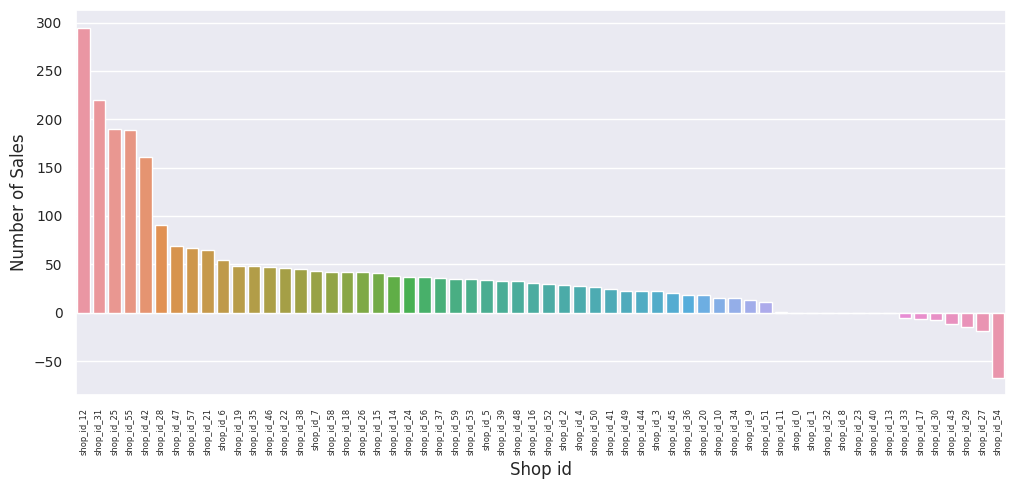

In [189]:
bar_plot_func(pred_shops_id_sales_local_df, "Shop id", "Number of Sales")

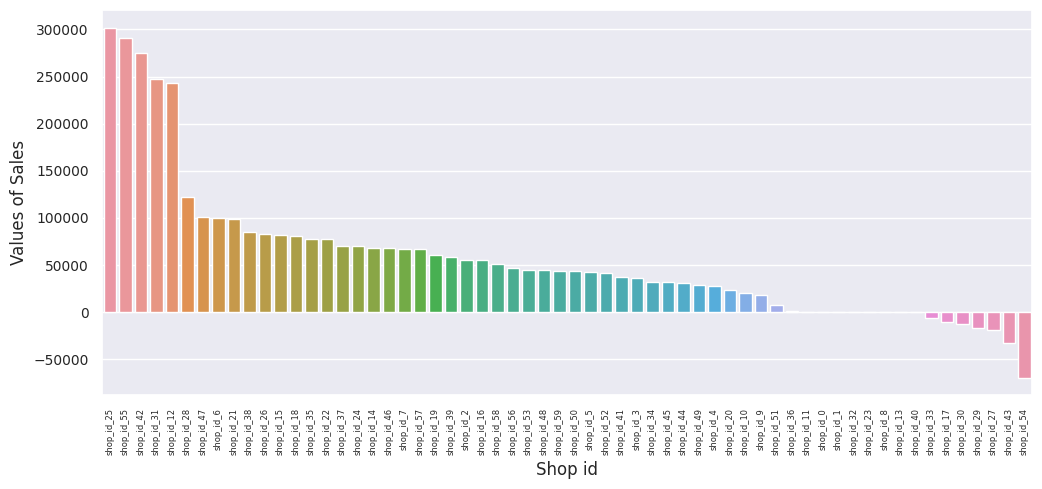

In [187]:
bar_plot_func(pred_shops_id_values_df, "Shop id", "Values of Sales")

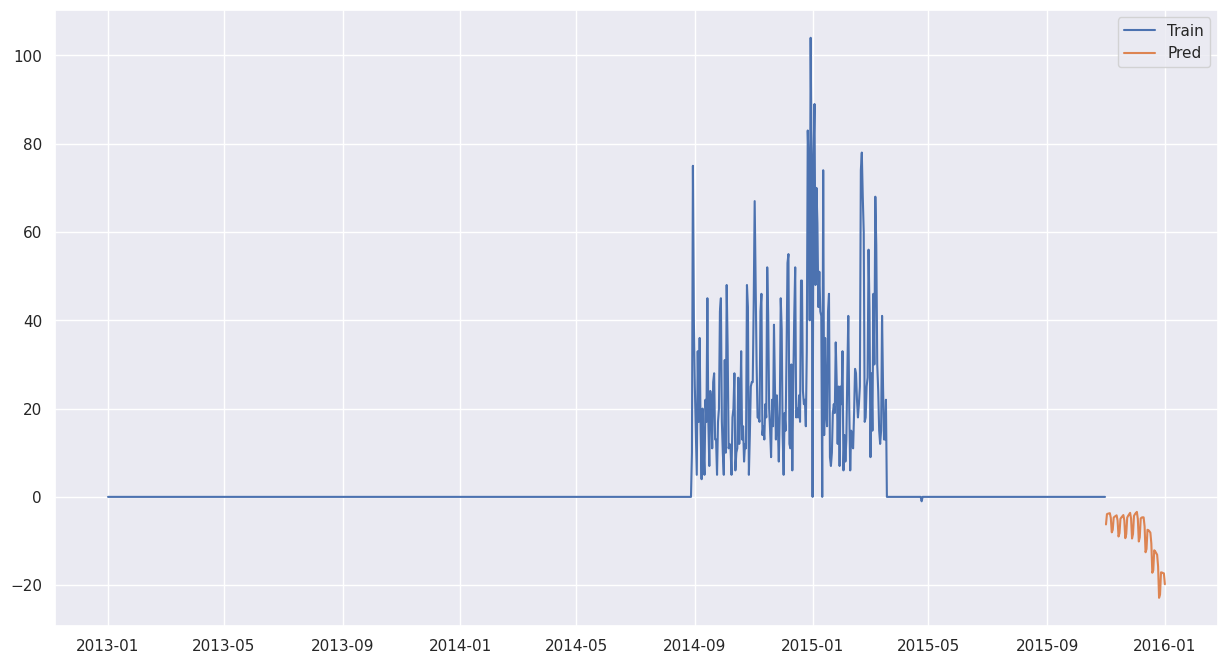

In [190]:
plot_forecast(prophet_shops_id_sales['shop_id_33'], test=False)

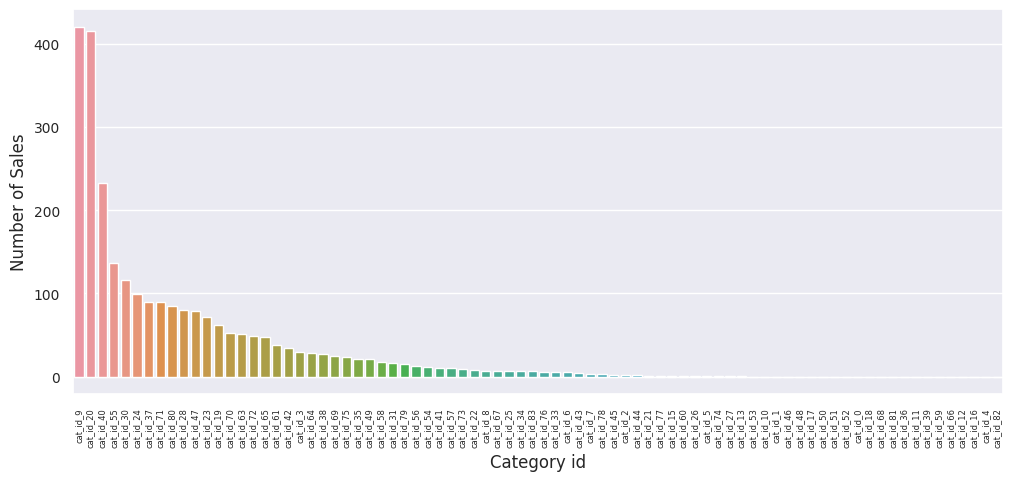

In [191]:
bar_plot_func(pred_cats_id_sales_local_df, "Category id", "Number of Sales")

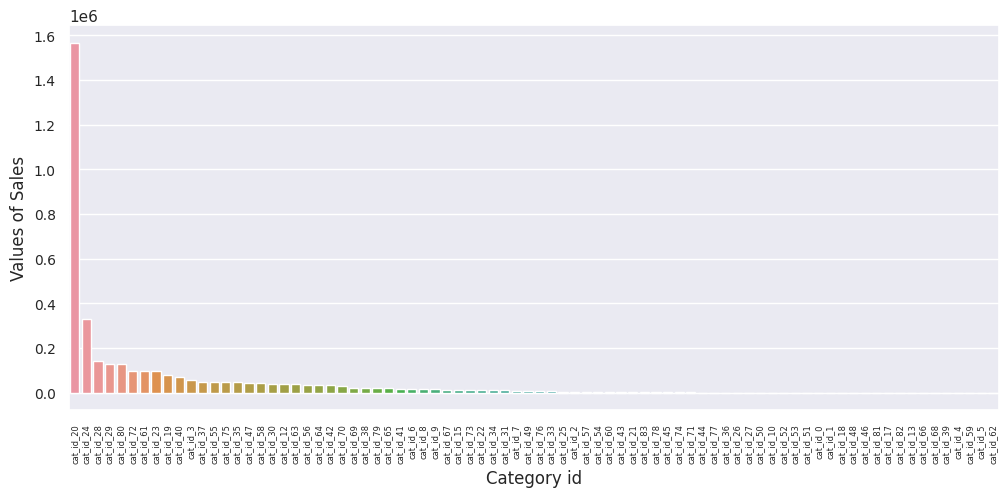

In [192]:
bar_plot_func(pred_cats_id_values_df, "Category id", "Values of Sales")

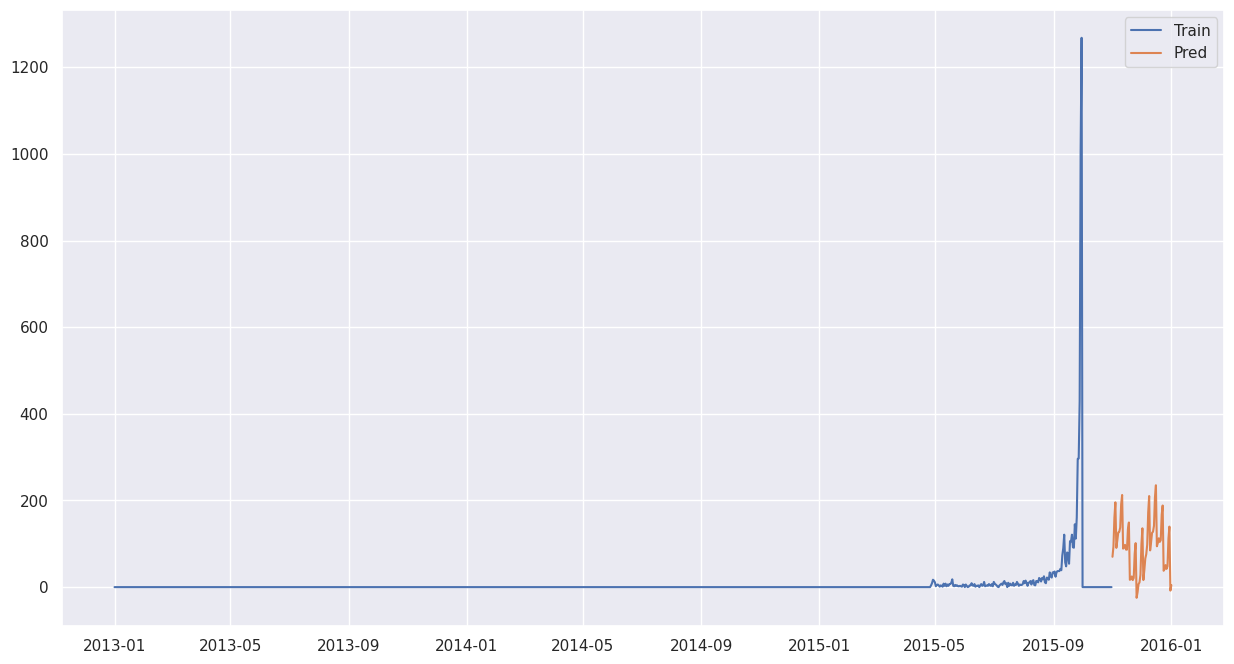

In [193]:
plot_forecast(prophet_cats_id_sales['cat_id_80'], test=False)

## Merge with test\_df

In [358]:
final_df = test_local_df.copy()
final_df = final_df.merge(shops_pred, how='left', on='shop_id')
final_df = final_df.merge(cat_pred, how='left', on='cat_id')
final_df = final_df.merge(items_pred, how='left', on='item_id')
final_df = final_df.merge(cats_shops_pred, how='left', on=['shop_id', 'cat_id'])
final_df.fillna(0, inplace=True)

In [359]:
final_df

ID  shop_id  item_id  cat_id  shops_n_sales  cats_n_sales  \
0            0        5     5037      19          34.00         62.38   
1            1        5     5320      55          34.00        136.88   
2            2        5     5233      19          34.00         62.38   
3            3        5     5232      23          34.00         71.56   
4            4        5     5268      20          34.00        415.41   
...        ...      ...      ...     ...            ...           ...   
214195  214195       45    18454      55          20.46        136.88   
214196  214196       45    16188      64          20.46         28.08   
214197  214197       45    15757      55          20.46        136.88   
214198  214198       45    19648      40          20.46        232.64   
214199  214199       45      969      37          20.46         90.05   

        items_n_sales  cat_shops_n_sales  
0                0.55               2.27  
1                0.00               2.75  
2                1.68               2.27  
3                1.03               2.22  
4                0.00               5.44  
...               ...                ...  
214195           0.02               2.33  
214196           0.04               0.50  
214197           0.24               2.33  
214198           0.08               2.08  
214199          -0.02               1.16  

[214200 rows x 8 columns]

In [446]:
final_df.to_csv('../raw_data/prophet/final.csv')

In [352]:
test_local_df

ID  shop_id  item_id  cat_id
0            0        5     5037      19
1            1        5     5320      55
2            2        5     5233      19
3            3        5     5232      23
4            4        5     5268      20
...        ...      ...      ...     ...
214195  214195       45    18454      55
214196  214196       45    16188      64
214197  214197       45    15757      55
214198  214198       45    19648      40
214199  214199       45      969      37

[214200 rows x 4 columns]

In [195]:
sample_local_df

ID  item_cnt_month
0            0             0.5
1            1             0.5
2            2             0.5
3            3             0.5
4            4             0.5
...        ...             ...
214195  214195             0.5
214196  214196             0.5
214197  214197             0.5
214198  214198             0.5
214199  214199             0.5

[214200 rows x 2 columns]

# Data Old and What?

## one

In [ ]:
shops_cats_sales = pd.pivot_table(
    sales_local_df, values='item_cnt_day',
    index=['shop_id', 'cat_id'], columns=['date'],
    aggfunc=np.sum 
)
shops_cats_sales.fillna(0, inplace=True)
#shops_cats_sales.reset_index(inplace=True)

In [ ]:
shops_cats_sales.T

In [ ]:
shops_sales

In [ ]:
shops_items_sales = pd.pivot_table(
    sales_local_df, values='item_cnt_day',
    index=['shop_id', 'item_id'], columns=['date_block_num'],
    aggfunc=np.sum 
)
shops_items_sales.fillna(0, inplace=True)
#shops_items_sales.reset_index(inplace=True)

In [ ]:
shops_items_sales

In [ ]:
shops_sales_month['final_id'] = shops_sales_month['shop_id'].astype(str) + "-" + shops_sales_month['item_id'].astype(str)
shops_sales_month.set_index('final_id', inplace=True)
shops_sales_month.drop(columns=['shop_id', 'item_id'], inplace=True)
shops_sales_month = shops_sales_month.T

In [ ]:
shops_sales_month

In [ ]:
plot_cols = ['0-32', '0-49', '59-22144', '59-22167']
plot_features = shops_sales_month[plot_cols]
plot_features.index = shops_sales_month.index
plot_features.plot(subplots = True);

## two

In [ ]:
sales_local_df[sales_local_df['shop_id'] == 10].sort_values("date").groupby(by='date').sum('item_cnt_day')

In [ ]:
shop_sales_month =pd.DataFrame({"date_block_num": range(34)})
type(shop_sales_month)

In [ ]:
total_month_dict = {}
for id in range(shops_local_df.shape[0]):
    shop_id = f"shop_id_{id}"
    df = sales_local_df[sales_local_df['shop_id'] == id].groupby(by='date_block_num').sum('item_cnt_day')
    total_month_dict[shop_id] = df.shape[0]
    shop_sales_month[shop_id] = df.item_cnt_day
shop_sales_month.fillna(0, inplace=True)
shop_sales_month.drop(columns=['date_block_num'], inplace=True)

In [ ]:
shop_sales_month

In [ ]:
closed_shops = shop_sales_month.iloc[31:34]
closed_shops = pd.DataFrame(shop_sales_month.iloc[31:34].sum()).T
closed_shops

In [ ]:
pd.DataFrame(shop_sales_month.iloc[31:34].sum()).head(60)

In [ ]:
plt.plot(shop_sales_month.shop_id_0)
plt.plot(shop_sales_month.shop_id_1)
plt.plot(shop_sales_month.shop_id_8)
plt.plot(shop_sales_month.shop_id_9)

plt.plot(shop_sales_month.shop_id_11)
plt.plot(shop_sales_month.shop_id_13)
plt.plot(shop_sales_month.shop_id_17)
plt.plot(shop_sales_month.shop_id_20)
plt.plot(shop_sales_month.shop_id_23)
plt.plot(shop_sales_month.shop_id_27)

plt.plot(shop_sales_month.shop_id_29)
plt.plot(shop_sales_month.shop_id_30)
plt.plot(shop_sales_month.shop_id_32)
plt.plot(shop_sales_month.shop_id_33)
plt.plot(shop_sales_month.shop_id_40)
plt.plot(shop_sales_month.shop_id_27)


plt.plot(shop_sales_month.shop_id_43)
plt.plot(shop_sales_month.shop_id_51)
plt.plot(shop_sales_month.shop_id_54)
plt.plot(range(34))

In [ ]:
plt.plot(shop_sales_month.shop_id_27)
#plt.plot(shop_sales_month.shop_id_41)
#plt.plot(shop_sales_month.shop_id_42)
#plt.plot(shop_sales_month.shop_id_43)
#plt.plot(shop_sales_month.shop_id_44)
#plt.plot(shop_sales_month.shop_id_45)
#plt.plot(shop_sales_month.shop_id_46)

In [ ]:
sns.displot(total_month_dict, bins=34)
plt.xlim(1, 35, )

In [ ]:
total_month_dict

In [ ]:
open_shops